In [ ]:
from openpyxl import load_workbook, Workbook

# 엑셀 파일 경로
input_file = "D:\\네오룩.xlsx"
output_file = "D:\\네오룩_전시.xlsx"

try:
    # 입력 엑셀 파일 로드
    wb = load_workbook(input_file)
    ws = wb.active
    
    # 새 워크북 생성
    new_wb = Workbook()
    new_ws = new_wb.active
    
    # 헤더 찾기
    headers = []
    year_col = None
    month_col = None
    title_col = None
    contents_col = None
    
    for col in range(1, ws.max_column + 1):
        cell_value = ws.cell(row=1, column=col).value
        headers.append(cell_value)
        if cell_value == 'Year':
            year_col = col
        elif cell_value == 'Month':
            month_col = col
        elif cell_value == 'Title':
            title_col = col
        elif cell_value == 'Contents':
            contents_col = col
    
    # 필요한 열이 존재하는지 확인
    if None in (year_col, month_col, title_col, contents_col):
        missing_cols = []
        if year_col is None: missing_cols.append('Year')
        if month_col is None: missing_cols.append('Month')
        if title_col is None: missing_cols.append('Title')
        if contents_col is None: missing_cols.append('Contents')
        raise KeyError(f"필요한 열이 없습니다: {', '.join(missing_cols)}")
    
    # 헤더 추가
    new_ws.append(['Year', 'Month', 'Title', 'Contents'])
    
    # '展'을 포함하는 행 찾기 및 새 워크시트에 추가
    count = 0
    for row in range(2, ws.max_row + 1):
        contents = ws.cell(row=row, column=contents_col).value
        if contents and '展' in str(contents):
            year = ws.cell(row=row, column=year_col).value
            month = ws.cell(row=row, column=month_col).value
            title = ws.cell(row=row, column=title_col).value
            new_ws.append([year, month, title, contents])
            count += 1
    
    # 결과 저장
    new_wb.save(output_file)
    
    print(f"처리 완료: {count}개의 행이 '{output_file}'에 저장.")

except FileNotFoundError:
    print(f"오류: '{input_file}' 파일을 찾을 수 없습니다.")
except KeyError as e:
    print(f"오류: {e}")
except Exception as e:
    print(f"오류 발생: {e}")
    import traceback
    traceback.print_exc()  # 상세한 오류 정보 출력

처리 완료: 47455개의 행이 'D:\네오룩_전시.xlsx'에 저장되었습니다.


In [6]:
#명사 토크나이징 작업

from kiwipiepy import Kiwi
import pandas as pd
import re
from collections import Counter

# Kiwi 설정 및 사용자 단어 추가
kiwi = Kiwi()
user_words = [
    ('산업사회', 'NNP', 0),
    ('미술계', 'NNP', 0),
    ('미술씬', 'NNP', 0),
    ('현대미술', 'NNP', 0),
    ('동시대미술', 'NNP', 0),
    ('우리나라', 'NNP', 0),
    ('우리', 'NNP', 0)
]

# 각 단어를 개별적으로 추가
for word, tag, score in user_words:
    kiwi.add_user_word(word, tag, score)

# 한자-한글 변환과 수정
def replace_hanja(text):
    if not isinstance(text, str):
        return ''
    # 모든 한자를 제거합니다
    return re.sub(r'[一-鿕]', '', text)

# 특수기호 및 잘못된 XML 문자 제거
def remove_special_characters(text):
    # 여기에서 XML에서 사용할 수 없는 문자를 제거합니다.
    return re.sub(r'[^\x20-\x7E가-힣\s]', '', text)

# 숫자 제거
def remove_numbers(text):
    # Keep numbers followed by '년대'
    return re.sub(r'(?<!\d)(\d+년대)(?!\d)|\d+', lambda m: m.group(1) if m.group(1) else '', text)

# 불용어 처리
stopwords = set([
    '천백원','천원','만원','백원','후시','전시','월일','년월','년월일','일오','사항',
    '통해', '가게','가기','가까이','가도','주의', '정말','덕분',
    '때문','이번','년대','가지','로서','모든','무엇','또한','다시','대해','사이','방식','위해','자체',
    '가장','이제','바로','여러','대한','그것','다른','서로', '거의', '중인','대부분',
    '마치','이자','기도','경우','더욱','거나','하다','하나','생각','시작','이후','동안','부분',
    '내용','있음','결국','누구','만큼','특정','개최','처음','번째','어디','제목','이름','로부터'
])

# 유의어 처리
replacement_dict = {
    '아티스트': '미술가',
    '아트': '예술',
    '아트씬': '미술씬',
    '아트신': '미술씬',
    '아트 씬': '미술씬',
    '몸': '신체',
    '바디': '신체',
    '인체': '신체',
    '육체': '신체',
    '여자': '여성',
    '남자': '남성',
    '현대 미술': '현대미술',
    '동시대 미술':'동시대미술',
    '당대 미술': '동시대미술',
    '당대미술': '동시대미술',
    '한국 미술': '한국미술',
    '자기': '자신',
    '대안 공간': '대안공간',
    ' 나는 ': ' 본인은 ',
    ' 나의 ': ' 본인의 ',
    ' 나를 ': ' 본인을 ',
    ' 내가 ': ' 본인이 ',
    ' 나와 ' : ' 본인과 ',
    ' 내게 ' : ' 본인에게 ',
    ' 나에게' : ' 본인에게'

}

def replace_words(text, replacement_dict):
    for old_word, new_word in replacement_dict.items():
        text = text.replace(old_word, new_word)
    return text

def merge_custom_words(tokens, custom_dict):
    merged_tokens = []
    skip = 0
    for i in range(len(tokens)):
        if skip:
            skip -= 1
            continue
        word = tokens[i]
        if i+1 < len(tokens) and tokens[i] + tokens[i+1] in custom_dict:
            merged_tokens.append(tokens[i] + tokens[i+1])
            skip = 1
        else:
            merged_tokens.append(word)
    return merged_tokens

# 명사 추출 및 토큰화
def tokenize_with_kiwi(text):
    text = remove_special_characters(text)
    text = replace_hanja(text)
    text = replace_words(text, replacement_dict)
    text = text.lower()
    text = remove_numbers(text)
    tokens = []
    for word, tag, start, length in kiwi.analyze(text, top_n=1)[0][0]:
        if tag in ['NNP', 'NNG'] and word not in stopwords and len(word) > 1:
            tokens.append(word)
    return ' '.join(tokens)

# 엑셀 파일 불러오기
file_path = 'D:\\네오룩_전시.xlsx'
df = pd.read_excel(file_path)

# 적절한 열 이름을 확인
text_column = 'Contents'
df['Token'] = ''

total_rows = len(df)
save_interval = 5000

output_file_path = 'D:\\Neolook_Expo_Token.xlsx'

# 진행 상황 안내 및 중간 저장을 위한 루프
for i in range(0, total_rows, save_interval):
    end_index = min(i + save_interval, total_rows)
    df.loc[i:end_index-1, 'Token'] = df.loc[i:end_index-1, text_column].fillna('').apply(tokenize_with_kiwi)

    # 진행 상황 안내
    print(f"{end_index}건 처리")

    # 진행 상황 저장
    df[['Year', 'Month', 'Title', 'Token']].to_excel(output_file_path, index=False)

print(f"모든 행 처리")

5000건 처리
10000건 처리
15000건 처리
20000건 처리
25000건 처리
30000건 처리
35000건 처리
40000건 처리
45000건 처리
47455건 처리
모든 행 처리


In [5]:
import pandas as pd
from collections import Counter
import os
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# 엑셀 파일 읽기
file_path = r'D:\네오룩_전시_Token.xlsx'
df = pd.read_excel(file_path)

# 원본 파일과 같은 경로에 저장
output_path = os.path.join(os.path.dirname(file_path), '네오룩_전시_Freq.xlsx')

# 파일 생성
writer = pd.ExcelWriter(output_path, engine='xlsxwriter')

# 1. 'Year' 열을 기준으로 연도별 전시횟수 집계 및 오름차순 정렬
year_counts = df['Year'].value_counts().reset_index()
year_counts.columns = ['Year', 'Ex-Count']
year_counts = year_counts.sort_values(by='Year', ascending=True)  # 연도별 오름차순 정렬
year_counts.to_excel(writer, sheet_name='연도별 전시 수', index=False)

# 2. 'Token' 열의 단어들을 모두 집계하여 빈도수 및 문서수 측정 (상위 200개 단어)
tokens = df['Token'].str.cat(sep=' ').split()
token_counts = Counter(tokens).most_common(200)

# 각 단어가 등장한 문서 수 계산
def calculate_doc_count(token):
    return df['Token'].apply(lambda x: token in str(x)).sum()

token_counts_with_docs = [(tk, freq, calculate_doc_count(tk)) for tk, freq in token_counts]

# Gensim을 사용하여 TF-IDF 계산
texts = [doc.split() for doc in df['Token'].dropna()]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf_model = TfidfModel(corpus)

# TF-IDF 값을 데이터프레임에 추가
tfidf_scores = {dictionary[id]: score for doc in tfidf_model[corpus] for id, score in doc}
token_df = pd.DataFrame(token_counts_with_docs, columns=['Token', 'Frequency', 'Doc Count'])
token_df['TF-IDF'] = token_df['Token'].apply(lambda x: tfidf_scores.get(x, 0))

# 각 단어가 포함된 문서에서 평균 몇 회씩 등장하는지 계산
token_df['Average Occurrences'] = token_df.apply(lambda row: row['Frequency'] / row['Doc Count'], axis=1)

# 각 단어가 포함된 문서의 백분율 계산 (소수점 두자리까지)
total_docs = df.shape[0]
token_df['Doc Percentage'] = token_df['Doc Count'].apply(lambda x: round((x / total_docs) * 100, 2))

# 상위 200개 단어 추출 후 빈도수 기준 내림차순 정렬
token_df = token_df.head(200).sort_values(by='Frequency', ascending=False)  # Frequency 기준 내림차순 정렬
token_df = token_df[['Token', 'Frequency', 'TF-IDF', 'Doc Count', 'Doc Percentage', 'Average Occurrences']]
token_df.to_excel(writer, sheet_name='상위 200', index=False)

# 터미널 출력
print(token_df)

# 3. 연도별 상위 100개 단어 및 빈도수, 문서수/전체 문서수 집계
yearly_top_100_tokens = df.groupby('Year')['Token'].apply(lambda x: Counter(" ".join(x.dropna()).split()).most_common(100))
year_total_docs = df.groupby('Year').size()

# 데이터프레임 생성
data = []
for year, tokens in yearly_top_100_tokens.items():
    row = [year]
    total_docs = year_total_docs.loc[year]
    for tk, freq in tokens:
        doc_count = df[(df['Year'] == year) & (df['Token'].str.contains(tk, na=False))].shape[0]
        row.append(f"{tk}({freq}, {doc_count}/{total_docs})")
    data.append(row)

# 최대 열 수에 맞추어 데이터 정리
max_columns = max(len(row) for row in data)
data = [row + [''] * (max_columns - len(row)) for row in data]

# 열 이름 생성
columns = ['Year'] + [f'{i + 1}위' for i in range(max_columns - 1)]

# 데이터프레임 생성
yearly_top_100_df = pd.DataFrame(data, columns=columns)
yearly_top_100_df = yearly_top_100_df.sort_values(by='Year', ascending=True)  # 연도별 오름차순 정렬

# 연도별 상위 100개 단어 시트에 저장
yearly_top_100_df.to_excel(writer, sheet_name='연도별 상위 100개 단어', index=False)

# 엑셀 파일 저장
writer.close()

    Token  Frequency    TF-IDF  Doc Count  Doc Percentage  Average Occurrences
0      작가     276566  0.010265      35856           75.56             7.713242
1      작품     192249  0.024235      33005           69.55             5.824845
2      작업     152072  0.018611      32156           67.76             4.729195
3      공간     128280  0.018923      27513           57.98             4.662523
4      자신     111889  0.021961      29409           61.97             3.804584
..    ...        ...       ...        ...             ...                  ...
195    우주      10842  0.018227       4843           10.21             2.238695
196    구체      10837  0.019764       7170           15.11             1.511437
197    시절      10795  0.047193       6612           13.93             1.632638
198    자아      10763  0.057795       5045           10.63             2.133399
199    영화      10740  0.027072       5030           10.60             2.135189

[200 rows x 6 columns]


In [ ]:
import pandas as pd
import pickle

# 데이터 로드
file_path = 'D:\\네오룩_전시_Token.xlsx'
df = pd.read_excel(file_path)

# Token 열에서 일부 단어 제외하기
def filter_tokens(tokens):
    if isinstance(tokens, str):
        # 공백으로 구분된 문자열을 리스트로 변환
        token_list = tokens.split()

        # 예외 단어
        filtered_tokens = [token for token in token_list if token not in ['콸콸', '꿀꿀']]

        # 공백으로 구분된 문자열로 변환
        return ' '.join(filtered_tokens)
    return tokens

# Token 열 필터링 적용
if 'Token' in df.columns:
    df['Token'] = df['Token'].apply(filter_tokens)

# 파일을 pkl 형식으로 저장
pkl_file_path = 'D:\\네오룩_전시_Token.pkl'
with open(pkl_file_path, 'wb') as f:
    pickle.dump(df, f)

print(f"데이터가 {pkl_file_path} 파일로 저장.")

# pkl 파일 로드하여 확인
with open(pkl_file_path, 'rb') as f:
    loaded_df = pickle.load(f)

# 자료 확인을 위해 5개 문서를 터미널 출력
print(loaded_df.head(5))

데이터가 D:\네오룩_전시_Token.pkl 파일로 저장.
   Year  Month                                Title  \
0  2000      1    이재삼展 / LEEJAESAM / 李在三 / painting   
1  2000      1  박형주展 / PARKHYUNGJU / 朴炯姝 / painting   
2  2000      1                 느림_Slowness of Speed   
3  2000      1                                  벽사전   
4  2000      1                   김석원展 / photography   

                                               Token  
0  오브제 쉬제 작업 출발 세계 언급 화폭 자신 신체 시간 공간 사유 성찰 흔적 사유 ...  
1  본인 공간 시간 테두리 생활 인식 구속 느낌 일상생활 시간 공간 모습 자리 확인 작...  
2  근대 과정 야기 일상 속도 기획 예술 선재 센터 호주 멜버른 빅토리아 미술관 시드니...  
3  디지털 신명 조화 회복 사전 천지개벽 호들갑 흥분 고대 천년 시간 동일 단위 분절 ...  
4  여인 김석원 사진 특수 상황 사진 여인 여관 한정 공간 어스름 조명 침대 커버 다양...  


저장된 결과 파일 로드.
이전에 저장된 결과 로드.
Number of Topics: 20, Perplexity: -8.347587027605472, Coherence: 0.4737127105655766
Number of Topics: 21, Perplexity: -8.370123170327743, Coherence: 0.49287895187126823
Number of Topics: 22, Perplexity: -8.4013423588372, Coherence: 0.48462814158076734
Number of Topics: 23, Perplexity: -8.427395206092479, Coherence: 0.4858055130219871
Number of Topics: 24, Perplexity: -8.455113834757801, Coherence: 0.4942868278085634
Number of Topics: 25, Perplexity: -8.482802337029774, Coherence: 0.49190732245076413
Number of Topics: 26, Perplexity: -8.51003101056954, Coherence: 0.49161185572589255
Number of Topics: 27, Perplexity: -8.538943071939277, Coherence: 0.48213743894415395
Number of Topics: 28, Perplexity: -8.567818901048563, Coherence: 0.4889096801915075
Number of Topics: 29, Perplexity: -8.592451315462043, Coherence: 0.4967442122502205
Number of Topics: 30, Perplexity: -8.622482801824798, Coherence: 0.49310100521958145
Number of Topics: 31, Perplexity: -8.6504822

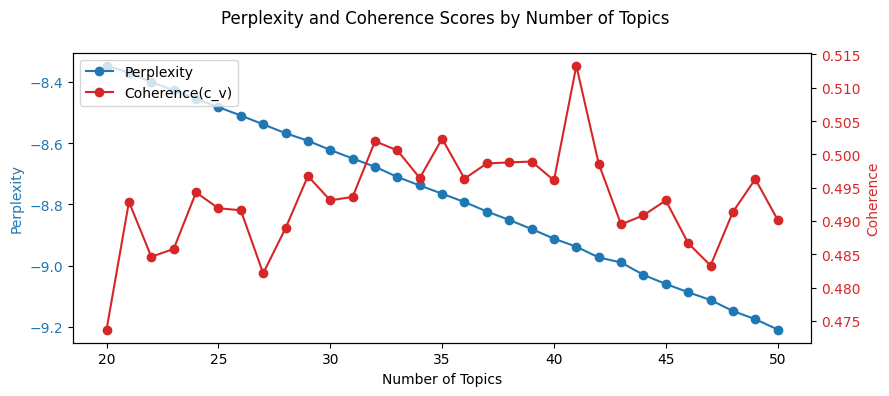

Dictionary와 Corpus가 D:\네오룩_전시\네오룩_전시_corpus_dict.pkl에 저장되었습니다.


In [1]:
import pandas as pd
import numpy as np
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pickle
import matplotlib.pyplot as plt
import os

# 폴더 경로 설정
folder_path = 'D:\\네오룩_전시'
os.makedirs(folder_path, exist_ok=True)  # 폴더가 없는 경우 생성

# 데이터 로드
pkl_file_path = os.path.join('D:\\네오룩_전시_Token.pkl')
with open(pkl_file_path, 'rb') as f:
    df = pickle.load(f)

# 전처리된 텍스트 사용
def process_token(token):
    if isinstance(token, float):
        return str(token).split()
    return token.split()

processed_texts_Keyword = df['Token'].apply(process_token)

# 토큰 생성 및 코퍼스 생성
dictionary = corpora.Dictionary(processed_texts_Keyword)
dictionary.filter_extremes(no_below=10)
corpus = [dictionary.doc2bow(text) for text in processed_texts_Keyword]

# 저장된 결과 파일 경로 설정
results_file = os.path.join(folder_path, '네오룩_전시_Coherence.pkl')

# 이미 계산된 결과가 있는지 확인
if os.path.exists(results_file):
    print("저장된 결과 파일 로드.")
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # 결과 데이터 추출
    topic_range = results['topic_range']
    perplexity_values = results['perplexity_values']
    coherence_values = results['coherence_values']
    
    print("이전에 저장된 결과 로드.")
    
    # 각 토픽별 퍼플렉시티와 응집도 출력
    for i, num_topics in enumerate(topic_range):
        print(f'Number of Topics: {num_topics}, Perplexity: {perplexity_values[i]}, Coherence: {coherence_values[i]}')
else:
    print("새로 계산을 시작.")
    # 난수 생성기 시드 설정
    np.random.seed(0)

    # 퍼플렉시티와 토픽 응집도 계산
    perplexity_values = []
    coherence_values = []
    topic_range = range(20, 51)
    random_seed = 0  # 난수 시드 설정
    passes_freq = 20  # 학습 빈도 설정

    for num_topics in topic_range:
        lda_model = LdaModel(
            corpus, num_topics=num_topics,
            id2word=dictionary,
            passes=passes_freq,
            random_state=random_seed,
            alpha='symmetric',
            eta='symmetric',
        )
        perplexity_values.append(lda_model.log_perplexity(corpus))
        coherence_model = CoherenceModel(model=lda_model, texts=processed_texts_Keyword, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

        # 토픽 개수별 결과 출력
        print(f'Number of Topics: {num_topics}, Perplexity: {perplexity_values[-1]}, Coherence: {coherence_values[-1]}')
    
    # 계산 결과 저장
    results = {
        'topic_range': list(topic_range),
        'perplexity_values': perplexity_values,
        'coherence_values': coherence_values
    }
    
    with open(results_file, 'wb') as f:
        pickle.dump(results, f)
    
    print(f"계산 결과가 {results_file}에 저장되었습니다.")


# 그래프 출력
fig, ax1 = plt.subplots(figsize=(9, 4))

# 퍼플렉시티 그래프
color = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(topic_range, perplexity_values, marker='o', color=color, label='Perplexity')
ax1.tick_params(axis='y', labelcolor=color)

# 토픽 응집도 그래프
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coherence', color=color)
ax2.plot(topic_range, coherence_values, marker='o', color=color, label='Coherence(c_v)')
ax2.tick_params(axis='y', labelcolor=color)

# 그래프 타이틀 및 레이아웃 조정
fig.suptitle('Perplexity and Coherence Scores by Number of Topics')
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.show()

# 추가로 dictionary와 corpus 저장
corpus_dict_file = os.path.join(folder_path, '네오룩_전시_corpus_dict.pkl')
corpus_dict_data = {
    'dictionary': dictionary,
    'corpus': corpus
}
with open(corpus_dict_file, 'wb') as f:
    pickle.dump(corpus_dict_data, f)
print(f"Dictionary와 Corpus가 {corpus_dict_file}에 저장되었습니다.")

# 저장된 데이터를 로드하는 예시 코드
def load_saved_data():
    # 결과 파일 로드
    with open(os.path.join(folder_path, '네오룩_전시_Coherence.pkl'), 'rb') as f:
        results = pickle.load(f)
    
    # Dictionary와 Corpus 로드
    with open(os.path.join(folder_path, '네오룩_전시_corpus_dict.pkl'), 'rb') as f:
        corpus_dict_data = pickle.load(f)
    
    dictionary = corpus_dict_data['dictionary']
    corpus = corpus_dict_data['corpus']
    
    print("모든 데이터가 성공적으로 로드되었습니다.")
    
    # 각 토픽별 퍼플렉시티와 응집도 출력
    topic_range = results['topic_range']
    perplexity_values = results['perplexity_values']
    coherence_values = results['coherence_values']
    
    for i, num_topics in enumerate(topic_range):
        print(f'Number of Topics: {num_topics}, Perplexity: {perplexity_values[i]}, Coherence: {coherence_values[i]}')
    
    return results, dictionary, corpus

# 필요시 아래 함수를 호출하여 저장된 데이터 로드
# results, dictionary, corpus = load_saved_data()

In [2]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
import pickle
import os

# 기본 폴더 경로 설정
base_folder = 'D:\\네오룩_전시'
os.makedirs(base_folder, exist_ok=True)  # 기본 폴더가 없는 경우 생성

# 이전에 저장한 corpus와 dictionary 불러오기
corpus_dict_file = os.path.join(base_folder, '네오룩_전시_corpus_dict.pkl')
if os.path.exists(corpus_dict_file):
    print("저장된 Corpus와 Dictionary를 불러옵니다...")
    with open(corpus_dict_file, 'rb') as f:
        corpus_dict_data = pickle.load(f)
        dictionary = corpus_dict_data['dictionary']
        corpus = corpus_dict_data['corpus']
    print("Corpus와 Dictionary를 성공적으로 불러왔습니다.")
else:
    print("저장된 Corpus와 Dictionary가 없습니다. 데이터 처리를 시작합니다...")
    # 데이터 로드
    pkl_file_path = os.path.join(base_folder, '네오룩_전시_Token.pkl')
    with open(pkl_file_path, 'rb') as f:
        df = pickle.load(f)

    # 전처리된 텍스트 사용
    def process_token(token):
        if isinstance(token, float):
            return str(token).split()
        return token.split()

    processed_texts_Keyword = df['Token'].apply(process_token)

    # 토큰 생성 및 코퍼스 생성
    dictionary = corpora.Dictionary(processed_texts_Keyword)
    dictionary.filter_extremes(no_below=10)
    corpus = [dictionary.doc2bow(text) for text in processed_texts_Keyword]
    print("Corpus와 Dictionary 생성 완료")

# 저장된 결과 파일 불러와서 최적 토픽 수 제안
results_file = os.path.join(base_folder, '네오룩_전시_Coherence.pkl')
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # 최적의 토픽 수 찾기
    coherence_values = results['coherence_values']
    topic_range = results['topic_range']
    optimal_idx = coherence_values.index(max(coherence_values))
    optimal_num_topics = list(topic_range)[optimal_idx]
    
    print(f"이전 계산 결과를 기반으로 제안하는 최적의 토픽 수: {optimal_num_topics} (Coherence: {coherence_values[optimal_idx]:.4f})")
    
    # 상위 5개 토픽 수 출력
    sorted_idx = sorted(range(len(coherence_values)), key=lambda i: coherence_values[i], reverse=True)[:5]
    print("응집도 기준 상위 5개 토픽 수:")
    for i in sorted_idx:
        print(f"토픽 수: {list(topic_range)[i]}, Coherence: {coherence_values[i]:.4f}")

# 여러 토픽 수 입력 받기
print("\n분석할 토픽 수를 한 개씩 입력하세요. 입력을 마치려면 빈 값으로 Enter를 누르세요.")
topic_numbers = []
while True:
    user_input = input("토픽 수 입력 (완료하려면 Enter): ")
    if not user_input:  # 빈 값이면 입력 종료
        break
    
    try:
        num = int(user_input)
        if num <= 0:
            print("양수를 입력해주세요.")
            continue
        topic_numbers.append(num)
        print(f"토픽 수 {num}이(가) 추가되었습니다.")
    except ValueError:
        print("유효한 숫자를 입력해주세요.")

if not topic_numbers:
    print("입력된 토픽 수가 없습니다. 프로그램을 종료합니다.")
    exit()

print(f"\n입력된 토픽 수: {', '.join(map(str, topic_numbers))}")

# 학습 빈도(passes) 입력 받기
while True:
    try:
        passes_freq = int(input("\n학습 빈도(passes)를 입력하세요 (기본값 20): ") or "20")
        if passes_freq <= 0:
            print("양수를 입력해주세요.")
            continue
        break
    except ValueError:
        print("유효한 숫자를 입력해주세요.")

random_seed = 0  # 난수 시드 설정

# 각 토픽 수에 대해 처리
for num_topics in topic_numbers:
    print(f"\n===== 토픽 수 {num_topics} 처리 시작 =====")
    
    # 토픽 수별 폴더 생성
    topic_folder_name = f'LDA {num_topics}'
    topic_folder_path = os.path.join(base_folder, topic_folder_name)
    os.makedirs(topic_folder_path, exist_ok=True)
    print(f"토픽 수 {num_topics}를 위한 폴더 확인/생성: {topic_folder_path}")

    # 모델 캐시 디렉토리 확인 및 생성 (토픽 폴더 내에 캐시 폴더 생성)
    cache_dir = os.path.join(topic_folder_path, '모델_캐시')
    os.makedirs(cache_dir, exist_ok=True)

    # 캐시된 모델과 결과 파일 경로
    model_cache_file = os.path.join(cache_dir, f'lda_model_{num_topics}_{passes_freq}.model')
    results_cache_file = os.path.join(cache_dir, f'lda_results_{num_topics}_{passes_freq}.pkl')

    # 캐시된 모델과 결과가 있는지 확인
    if os.path.exists(model_cache_file) and os.path.exists(results_cache_file):
        print(f"\n이전에 계산된 {num_topics}개 토픽, {passes_freq} passes의 결과를 불러옵니다...")
        
        # 모델 로드
        lda_model = LdaModel.load(model_cache_file)
        
        # 결과 로드
        with open(results_cache_file, 'rb') as f:
            cached_results = pickle.load(f)
            topics = cached_results['topics']
        
        print("캐시된 결과를 성공적으로 불러왔습니다.")
    else:
        print(f"\n{num_topics}개의 토픽과 {passes_freq}의 학습 빈도로 LDA 모델을 학습합니다...")
        
        # LDA 모델 학습
        lda_model = LdaModel(
            corpus, num_topics=num_topics,
            id2word=dictionary,
            passes=passes_freq,
            random_state=random_seed,
            alpha='symmetric',
            eta='symmetric',
        )
        
        # 각 토픽별 키워드와 기여도 계산
        num_keywords = 10
        topics = lda_model.show_topics(num_topics=num_topics, num_words=num_keywords, formatted=False)
        
        # 모델 저장
        lda_model.save(model_cache_file)
        
        # 결과 저장
        cached_results = {
            'topics': topics,
            'num_topics': num_topics,
            'passes_freq': passes_freq
        }
        with open(results_cache_file, 'wb') as f:
            pickle.dump(cached_results, f)
        
        print(f"새로 계산된 모델과 결과를 캐시에 저장했습니다.")

    # 데이터 저장을 위한 리스트 초기화
    data = []

    for topic in topics:
        topic_id = topic[0] + 1
        keywords_with_contributions = [f"{word[0]}({word[1]:.4f})" for word in topic[1]]
        keywords_str = ", ".join(keywords_with_contributions)
        contributions = [word[1] for word in topic[1]]

        # 터미널에 출력
        print(f"Topic {topic_id}: {keywords_str}")
        print(f"Topic {topic_id} Contributions: {', '.join([f'{contrib:.4f}' for contrib in contributions])}")

        # 엑셀 파일에 저장할 데이터 추가
        data.append([f"Topic {topic_id}"] + [word[0] for word in topic[1]])
        data.append([f"Topic {topic_id} Contributions"] + contributions)

    # 데이터프레임으로 변환
    df_result = pd.DataFrame(data)

    # 엑셀 파일로 저장
    output_file_path = os.path.join(topic_folder_path, f'LDA_{num_topics}_결과.xlsx')
    with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
        df_result.to_excel(writer, sheet_name='LDA', index=False, header=False)

    print(f"분석 결과가 {output_file_path} 파일로 저장되었습니다.")

    # 토픽 폴더 내에 모델 저장
    model_file = os.path.join(topic_folder_path, f'LDA_{num_topics}_model')
    lda_model.save(model_file)
    print(f"LDA 모델이 {model_file}에 저장되었습니다.")
    
    print(f"===== 토픽 수 {num_topics} 처리 완료 =====\n")


저장된 Corpus와 Dictionary를 불러옵니다...
Corpus와 Dictionary를 성공적으로 불러왔습니다.
이전 계산 결과를 기반으로 제안하는 최적의 토픽 수: 41 (Coherence: 0.5133)
응집도 기준 상위 5개 토픽 수:
토픽 수: 41, Coherence: 0.5133
토픽 수: 35, Coherence: 0.5023
토픽 수: 32, Coherence: 0.5020
토픽 수: 33, Coherence: 0.5006
토픽 수: 39, Coherence: 0.4989

분석할 토픽 수를 한 개씩 입력하세요. 입력을 마치려면 빈 값으로 Enter를 누르세요.
토픽 수 32이(가) 추가되었습니다.
토픽 수 33이(가) 추가되었습니다.
토픽 수 35이(가) 추가되었습니다.
토픽 수 39이(가) 추가되었습니다.
토픽 수 41이(가) 추가되었습니다.

입력된 토픽 수: 32, 33, 35, 39, 41

===== 토픽 수 32 처리 시작 =====
토픽 수 32를 위한 폴더 확인/생성: D:\네오룩_전시\LDA 32

이전에 계산된 32개 토픽, 20 passes의 결과를 불러옵니다...
캐시된 결과를 성공적으로 불러왔습니다.
Topic 1: 본인(0.1287), 마음(0.0259), 세상(0.0208), 감정(0.0205), 이야기(0.0201), 순간(0.0172), 모습(0.0166), 그림(0.0132), 우리(0.0088), 사랑(0.0065)
Topic 1 Contributions: 0.1287, 0.0259, 0.0208, 0.0205, 0.0201, 0.0172, 0.0166, 0.0132, 0.0088, 0.0065
Topic 2: 인간(0.0382), 욕망(0.0311), 얼굴(0.0218), 현실(0.0204), 인물(0.0165), 불안(0.0133), 죽음(0.0127), 모습(0.0125), 자아(0.0112), 상징(0.0105)
Topic 2 Contributions: 0.0382, 0.0311, 0.0218, 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
import string
import os

# 기본 폴더 경로 설정
base_folder = 'D:\\네오룩_전시'
os.makedirs(base_folder, exist_ok=True)  # 기본 폴더가 없는 경우 생성

# Excel 열 인덱스를 A, B, C, ... AA, AB, ... 형식으로 변환하는 함수
def excel_column_name(n):
    """0부터 시작하는 숫자를 엑셀 열 이름으로 변환 (A, B, C, ... AA, AB, ...)"""
    name = ""
    while n >= 0:
        name = string.ascii_uppercase[n % 26] + name
        n = n // 26 - 1
    return name

# 토픽 수 입력 받기
num_topics = int(input("결과를 시각화할 토픽 수를 입력하세요: "))

# 해당 토픽 폴더 경로 설정
topic_folder_path = os.path.join(base_folder, f'LDA {num_topics}')
if not os.path.exists(topic_folder_path):
    print(f"오류: 토픽 수 {num_topics}에 대한 폴더가 존재하지 않습니다.")
    print(f"먼저 토픽 모델링을 실행하여 '{topic_folder_path}' 폴더를 생성해주세요.")
    exit(1)

# 모델 파일 경로
model_file = os.path.join(topic_folder_path, f'LDA_{num_topics}_model')
if not os.path.exists(model_file):
    print(f"오류: '{model_file}' 모델 파일이 존재하지 않습니다.")
    exit(1)

# 코퍼스와 딕셔너리 로드
corpus_dict_file = os.path.join(base_folder, '네오룩_전시_corpus_dict.pkl')
if not os.path.exists(corpus_dict_file):
    print(f"오류: '{corpus_dict_file}' 코퍼스 및 딕셔너리 파일이 존재하지 않습니다.")
    exit(1)

print("코퍼스와 딕셔너리 파일을 로드합니다...")
with open(corpus_dict_file, 'rb') as f:
    corpus_dict_data = pd.read_pickle(f)
    dictionary = corpus_dict_data['dictionary']
    corpus = corpus_dict_data['corpus']

# 원본 데이터 로드 (Year 정보를 위해)
original_data_file = os.path.join('D:\\네오룩_전시_Token.pkl')
if not os.path.exists(original_data_file):
    print(f"오류: '{original_data_file}' 원본 데이터 파일이 존재하지 않습니다.")
    exit(1)

print("원본 데이터를 로드합니다...")
with open(original_data_file, 'rb') as f:
    df = pd.read_pickle(f)

# 모델 로드
from gensim.models import LdaModel
print(f"LDA 모델을 로드합니다: {model_file}")
lda_model = LdaModel.load(model_file)

# 연도별 각 문서의 토픽 분포 데이터 생성
print("토픽 분포를 분석합니다...")
years = df['Year']
doc_topics = [lda_model[corpus[i]] for i in range(len(corpus))]

# 소프트 할당을 위한 데이터프레임 생성
topic_weights_list = []
for i, doc_topic_probs in enumerate(doc_topics):
    year = years.iloc[i]
    # 각 문서의 모든 토픽 확률을 보존
    for topic_id, prob in doc_topic_probs:
        topic_weights_list.append({
            'Year': year,
            'Topic': topic_id,
            'Probability': prob
        })

topic_weights_df = pd.DataFrame(topic_weights_list)

# 연도별, 토픽별 확률 합계 계산
year_topic_sum = topic_weights_df.groupby(['Year', 'Topic'])['Probability'].sum().reset_index()
year_topic_pivot = year_topic_sum.pivot_table(index='Year', columns='Topic', values='Probability', fill_value=0)

# 토픽 번호를 1부터 시작하도록 수정
year_topic_pivot.columns = [f'Topic {i + 1}' for i in range(num_topics)]

# 연도별 총 확률 합계 (정규화 목적)
year_total = topic_weights_df.groupby('Year')['Probability'].sum()

# 연도별 토픽 비율 계산 (0-100%)
year_topic_ratio = year_topic_pivot.div(year_total, axis=0) * 100

# 토픽별 전체 가중치 합계 계산
topic_total_weights = topic_weights_df.groupby('Topic')['Probability'].sum().reset_index()
topic_total_weights['Topic'] = topic_total_weights['Topic'].apply(lambda x: f'Topic {x + 1}')

# 토픽 번호 순으로 정렬 (Topic 1, Topic 2, ...)
# 먼저 숫자 부분을 추출하고 정렬
topic_total_weights['Topic_Num'] = topic_total_weights['Topic'].str.extract(r'(\d+)').astype(int)
topic_total_weights = topic_total_weights.sort_values('Topic_Num')
topic_total_weights = topic_total_weights.drop('Topic_Num', axis=1)

# 토픽 폴더 내에 엑셀 파일 생성 경로 설정
output_filename = os.path.join(topic_folder_path, f'토픽분포_{num_topics}.xlsx')
print(f"엑셀 파일을 생성합니다: {output_filename}")
workbook = xlsxwriter.Workbook(output_filename)

# 스타일 설정
header_format = workbook.add_format({
    'bold': True,
    'font_color': 'white',
    'bg_color': '#1F4E78',
    'align': 'center',
    'border': 1
})

title_format = workbook.add_format({
    'bold': True,
    'font_size': 14,
    'align': 'center'
})

cell_format = workbook.add_format({
    'border': 1,
    'num_format': '0.00'  # 소수점 두 자리까지 표시
})

year_format = workbook.add_format({
    'border': 1,
    'align': 'center'
})

pct_format = workbook.add_format({
    'border': 1,
    'num_format': '0.00%'  # 백분율 형식으로 표시
})

# ================ 1. 토픽별 시트 (토픽별 전체 가중치 합계만 포함) ================
worksheet_topics = workbook.add_worksheet('토픽별')

# 토픽별 전체 가중치 합계만 추가
worksheet_topics.merge_range(0, 0, 0, 1, "토픽별 전체 가중치 합계", title_format)
worksheet_topics.write(1, 0, "토픽 ID", header_format)
worksheet_topics.write(1, 1, "가중치 합계", header_format)

# 토픽 ID 순서대로 가중치 합계 출력
for idx, (_, row) in enumerate(topic_total_weights.iterrows()):
    worksheet_topics.write(idx + 2, 0, row['Topic'], year_format)
    worksheet_topics.write(idx + 2, 1, row['Probability'], cell_format)

# 열 너비 설정
worksheet_topics.set_column(0, 0, 10)
for i in range(10):
    worksheet_topics.set_column(i * 2 + 1, i * 2 + 1, 15)  # 키워드 열
    worksheet_topics.set_column(i * 2 + 2, i * 2 + 2, 10)  # 기여도 열

# ================ 2. 연도별 시트 (전치된 데이터) ================
worksheet_years = workbook.add_worksheet('연도별')

# 제목 추가
worksheet_years.merge_range(0, 0, 0, num_topics, "연도별 토픽 분포", title_format)

# 전치된 데이터 (연도가 열, 토픽이 행)
transposed_weights = year_topic_pivot.transpose()
transposed_ratio = year_topic_ratio.transpose()

# 헤더 행 추가 (연도)
worksheet_years.write(1, 0, "토픽 ID", header_format)
for col, year in enumerate(transposed_weights.columns):
    worksheet_years.write(1, col + 1, int(year), header_format)

# 데이터 추가 - 확률 합계
for row, (topic, data) in enumerate(transposed_weights.iterrows()):
    worksheet_years.write(row + 2, 0, topic, year_format)
    for col, value in enumerate(data):
        worksheet_years.write(row + 2, col + 1, value, cell_format)

# 백분율 섹션 추가
start_row = num_topics + 3
worksheet_years.merge_range(start_row, 0, start_row, num_topics, "연도별 토픽 비율 (%)", title_format)

# 헤더 행 추가 (연도)
worksheet_years.write(start_row + 1, 0, "토픽 ID", header_format)
for col, year in enumerate(transposed_ratio.columns):
    worksheet_years.write(start_row + 1, col + 1, int(year), header_format)

# 데이터 추가 - 비율
for row, (topic, data) in enumerate(transposed_ratio.iterrows()):
    worksheet_years.write(start_row + row + 2, 0, topic, year_format)
    for col, value in enumerate(data):
        worksheet_years.write(start_row + row + 2, col + 1, value / 100, pct_format)

# 열 너비 설정
worksheet_years.set_column(0, 0, 15)
for col in range(1, len(transposed_weights.columns) + 1):
    worksheet_years.set_column(col, col, 10)

# ================ 3. 토픽 순위 시트 추가 ================
worksheet_rank = workbook.add_worksheet('토픽 순위')

# 토픽 가중치 합계로 다시 정렬 (내림차순)
topic_rank = topic_total_weights.sort_values('Probability', ascending=False).reset_index(drop=True)
topic_rank['Rank'] = topic_rank.index + 1

# 제목 추가
worksheet_rank.merge_range(0, 0, 0, 3, "토픽별 가중치 합계 순위", title_format)

# 헤더 행 추가
worksheet_rank.write(1, 0, "순위", header_format)
worksheet_rank.write(1, 1, "토픽 ID", header_format)
worksheet_rank.write(1, 2, "가중치 합계", header_format)
worksheet_rank.write(1, 3, "비율 (%)", header_format)

# 전체 가중치 합계 계산
total_weight = topic_rank['Probability'].sum()

# 데이터 추가
for row, (_, data) in enumerate(topic_rank.iterrows()):
    worksheet_rank.write(row + 2, 0, data['Rank'], year_format)  # 순위
    worksheet_rank.write(row + 2, 1, data['Topic'], year_format)  # 토픽
    worksheet_rank.write(row + 2, 2, data['Probability'], cell_format)  # 가중치 합계
    worksheet_rank.write(row + 2, 3, data['Probability'] / total_weight, pct_format)  # 비율

# 열 너비 설정
worksheet_rank.set_column(0, 0, 8)
worksheet_rank.set_column(1, 1, 12)
worksheet_rank.set_column(2, 2, 15)
worksheet_rank.set_column(3, 3, 12)

# ================ 4. 차트 추가 (토픽별 점유율만 포함) ================
worksheet_chart = workbook.add_worksheet('차트')

# 토픽 점유율 원형 차트 생성
pie_chart = workbook.add_chart({'type': 'pie'})
pie_chart.add_series({
    'name':       '토픽 점유율',
    'categories': f"='토픽 순위'!$B$3:$B${3+num_topics-1}",
    'values':     f"='토픽 순위'!$D$3:$D${3+num_topics-1}",
    'data_labels': {'percentage': True},
})

# 원형 차트 제목 설정
pie_chart.set_title({'name': '토픽별 점유율'})
pie_chart.set_size({'width': 720, 'height': 480})

# 원형 차트를 워크시트에 삽입
worksheet_chart.insert_chart('A30', pie_chart)

# 워크북 저장
workbook.close()

print(f"엑셀 파일 생성 완료: {output_filename}")

# 터미널에 토픽별 가중치 합계만 출력
print("\n===== 토픽별 전체 가중치 합계 =====")
for _, row in topic_total_weights.iterrows():
    print(f"{row['Topic']}: {row['Probability']:.2f}")

print("\n===== 토픽 순위 =====")
for i, (_, row) in enumerate(topic_rank.iterrows()):
    print(f"{i+1}위: {row['Topic']} ({row['Probability']:.2f}, {row['Probability']/total_weight*100:.2f}%)")

코퍼스와 딕셔너리 파일을 로드합니다...
원본 데이터를 로드합니다...
LDA 모델을 로드합니다: D:\네오룩_전시\LDA 41\LDA_41_model
토픽 분포를 분석합니다...
엑셀 파일을 생성합니다: D:\네오룩_전시\LDA 41\토픽분포_41.xlsx
엑셀 파일 생성 완료: D:\네오룩_전시\LDA 41\토픽분포_41.xlsx

===== 토픽별 전체 가중치 합계 =====
Topic 1: 1004.11
Topic 2: 710.07
Topic 3: 632.63
Topic 4: 2325.30
Topic 5: 797.33
Topic 6: 1212.33
Topic 7: 678.86
Topic 8: 1324.05
Topic 9: 576.73
Topic 10: 2278.36
Topic 11: 1629.96
Topic 12: 853.35
Topic 13: 217.85
Topic 14: 1141.79
Topic 15: 834.05
Topic 16: 767.18
Topic 17: 773.12
Topic 18: 2826.07
Topic 19: 685.84
Topic 20: 1295.97
Topic 21: 364.36
Topic 22: 728.07
Topic 23: 1003.67
Topic 24: 1827.19
Topic 25: 258.83
Topic 26: 941.71
Topic 27: 2372.13
Topic 28: 260.43
Topic 29: 2043.04
Topic 30: 1060.25
Topic 31: 3070.56
Topic 32: 651.88
Topic 33: 522.89
Topic 34: 189.94
Topic 35: 2332.77
Topic 36: 527.18
Topic 37: 762.59
Topic 38: 2998.66
Topic 39: 187.62
Topic 40: 818.50
Topic 41: 1128.00

===== 토픽 순위 =====
1위: Topic 31 (3070.56, 6.59%)
2위: Topic 38 (2998.66, 6.43%)


코퍼스와 딕셔너리 파일을 로드합니다...
원본 데이터를 로드합니다...
LDA 모델을 로드합니다: D:\네오룩_전시\LDA 41\LDA_41_model
데이터 연도 범위: 2000 ~ 2024


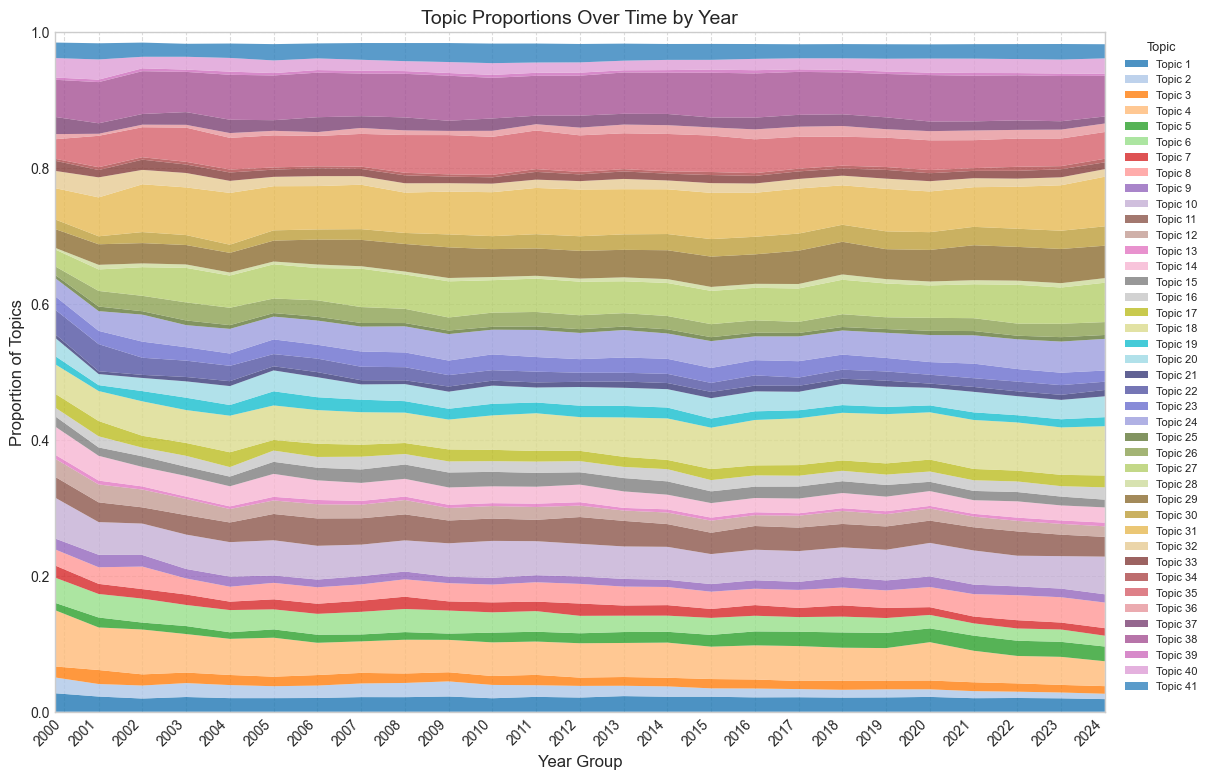

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from gensim.models import LdaModel
import pickle

# 기본 폴더 경로 설정
base_folder = 'D:\\네오룩_전시'
os.makedirs(base_folder, exist_ok=True)  # 기본 폴더가 없는 경우 생성

# 토픽 수 입력받기
num_topics = int(input("시각화할 토픽 수를 입력하세요: "))

# 해당 토픽 폴더 경로 설정
topic_folder_path = os.path.join(base_folder, f'LDA {num_topics}')
if not os.path.exists(topic_folder_path):
    print(f"오류: 토픽 수 {num_topics}에 대한 폴더가 존재하지 않습니다.")
    print(f"먼저 토픽 모델링을 실행하여 '{topic_folder_path}' 폴더를 생성해주세요.")
    exit(1)

# 모델 파일 경로
model_file = os.path.join(topic_folder_path, f'LDA_{num_topics}_model')
if not os.path.exists(model_file):
    print(f"오류: '{model_file}' 모델 파일이 존재하지 않습니다.")
    exit(1)

# 코퍼스와 딕셔너리 로드
corpus_dict_file = os.path.join(base_folder, '네오룩_전시_corpus_dict.pkl')
if not os.path.exists(corpus_dict_file):
    print(f"오류: '{corpus_dict_file}' 코퍼스 및 딕셔너리 파일이 존재하지 않습니다.")
    exit(1)

print("코퍼스와 딕셔너리 파일을 로드합니다...")
with open(corpus_dict_file, 'rb') as f:
    corpus_dict_data = pd.read_pickle(f)
    dictionary = corpus_dict_data['dictionary']
    corpus = corpus_dict_data['corpus']

# 원본 데이터 로드 (Year 정보를 위해)
original_data_file = os.path.join('D:\\네오룩_전시_Token.pkl')
if not os.path.exists(original_data_file):
    print(f"오류: '{original_data_file}' 원본 데이터 파일이 존재하지 않습니다.")
    exit(1)

print("원본 데이터를 로드합니다...")
with open(original_data_file, 'rb') as f:
    df = pd.read_pickle(f)

# 모델 로드
print(f"LDA 모델을 로드합니다: {model_file}")
lda_model = LdaModel.load(model_file)

# 연도 데이터 및 문서별 토픽 분포 계산
years = df['Year']
doc_topics = [lda_model[corpus[i]] for i in range(len(corpus))]

# 단위 입력받기
unit = int(input("연도 단위를 입력(예: 1, 5, 10): "))

# 연도 범위 계산
min_year = int(years.min())
max_year = int(years.max())
print(f"데이터 연도 범위: {min_year} ~ {max_year}")

# 각 문서의 토픽 비율을 데이터프레임으로 변환
doc_topic_ratios = []
for i, doc in enumerate(doc_topics):
    topic_ratio = [0] * num_topics
    for topic_id, ratio in doc:
        topic_ratio[topic_id] = ratio
    doc_topic_ratios.append(topic_ratio)

# DataFrame 생성
doc_topic_ratios_df = pd.DataFrame(doc_topic_ratios)
doc_topic_ratios_df['Year'] = years.values

# 새로운 방식으로 연도 그룹 생성
custom_groups = []
start_year = min_year
while start_year <= max_year:
    end_year = min(start_year + unit - 1, max_year)
    # 각 문서를 해당 그룹에 할당
    mask = (years >= start_year) & (years <= end_year)
    if mask.any():  # 해당 그룹에 문서가 있을 경우만 추가
        custom_groups.append((start_year, end_year))
    start_year = end_year + 1

# 이전 그룹화 방식 대신 새로운 그룹화 적용
doc_topic_ratios_df['Year_Group'] = None
for start, end in custom_groups:
    mask = (doc_topic_ratios_df['Year'] >= start) & (doc_topic_ratios_df['Year'] <= end)
    doc_topic_ratios_df.loc[mask, 'Year_Group'] = start

# 단위로 묶은 연도별 토픽 비율 계산
yearly_topic_ratios = doc_topic_ratios_df.groupby('Year_Group').mean()

# 토픽 번호를 1부터 시작하도록 수정
if 'Year' in yearly_topic_ratios.columns:
    yearly_topic_ratios = yearly_topic_ratios.drop(columns=['Year'])
yearly_topic_ratios.columns = [f'Topic {i + 1}' for i in range(num_topics)]

# 다중 colormap 사용
colors = plt.get_cmap('tab20').colors + plt.get_cmap('tab20b').colors + plt.get_cmap('tab20c').colors

# 영역 차트 생성
fig, ax = plt.subplots(figsize=(14, 8))

# 그래프가 축을 꽉 채우도록 설정
fig.tight_layout(pad=0)
ax.margins(0, 0)  # x, y 여백 제거

# 그룹 레이블 생성 (각 단위의 시작값으로 출력, 마지막 부분만 특별 처리)
x_labels = []
for i, (start, end) in enumerate(custom_groups):
    # 마지막 그룹이고 그룹 크기가 입력값보다 작은 경우
    if i == len(custom_groups) - 1 and (end - start + 1) < unit:
        x_labels.append(f"{start}-{end}")
    else:
        x_labels.append(f"{start}")

# 누적 영역 차트 그리기
ax.stackplot(range(len(yearly_topic_ratios)),
             [yearly_topic_ratios[col] for col in yearly_topic_ratios.columns],
             labels=yearly_topic_ratios.columns,
             colors=colors[:num_topics],
             alpha=0.8)

# x축 레이블 설정 - 첫 번째 레이블의 위치 조정
positions = list(range(len(yearly_topic_ratios)))
if positions:  # 비어있지 않은 경우에만 조정
    positions[0] = 0.2  # 첫 번째 레이블 위치를 약간 오른쪽으로 조정
plt.xticks(positions, x_labels, rotation=45, ha='right')

# 축 및 제목 설정
ax.set_xlabel('Year Group', fontsize=12)
ax.set_ylabel('Proportion of Topics', fontsize=12)

# 단위에 따른 제목 설정
if unit == 1:
    title_unit = "Year"
else:
    title_unit = f"{unit}-Year Groups"
ax.set_title(f'Topic Proportions Over Time by {title_unit}', fontsize=14)

# 범례 설정
ax.legend(title='Topic', bbox_to_anchor=(1.01, 1),
          loc='upper left', fontsize=8, title_fontsize=9)

# 그리드 추가
ax.grid(True, linestyle='--', alpha=0.7)

# x축 여백 제거 및 범위 정확히 설정
if len(yearly_topic_ratios) > 0:
    plt.xlim(0, len(yearly_topic_ratios) - 1)

# y축 범위도 0부터 1까지 정확히 설정
plt.ylim(0, 1)

# 레이아웃 조정 - 여백 최소화
plt.tight_layout(pad=0.5)
plt.subplots_adjust(left=0.05, right=0.8, top=0.95, bottom=0.1)

# 그래프 표시
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import io
import base64
import os
from gensim.models import LdaModel
import matplotlib.font_manager as fm
import subprocess
import pickle

# 기본 폴더 경로 설정
base_folder = 'D:\\네오룩_전시'
os.makedirs(base_folder, exist_ok=True)  # 기본 폴더가 없는 경우 생성

# 토픽 수 입력받기
num_topics = int(input("시각화할 토픽 수를 입력하세요: "))

# 해당 토픽 폴더 경로 설정
topic_folder_path = os.path.join(base_folder, f'LDA {num_topics}')
if not os.path.exists(topic_folder_path):
    print(f"오류: 토픽 수 {num_topics}에 대한 폴더가 존재하지 않습니다.")
    print(f"먼저 토픽 모델링을 실행하여 '{topic_folder_path}' 폴더를 생성해주세요.")
    exit(1)

# 모델 파일 경로
model_file = os.path.join(topic_folder_path, f'LDA_{num_topics}_model')
if not os.path.exists(model_file):
    print(f"오류: '{model_file}' 모델 파일이 존재하지 않습니다.")
    exit(1)

# 코퍼스와 딕셔너리 로드
corpus_dict_file = os.path.join(base_folder, '네오룩_전시_corpus_dict.pkl')
if not os.path.exists(corpus_dict_file):
    print(f"오류: '{corpus_dict_file}' 코퍼스 및 딕셔너리 파일이 존재하지 않습니다.")
    exit(1)

print("코퍼스와 딕셔너리 파일을 로드합니다...")
with open(corpus_dict_file, 'rb') as f:
    corpus_dict_data = pickle.load(f)
    dictionary = corpus_dict_data['dictionary']
    corpus = corpus_dict_data['corpus']

# 원본 데이터 로드 (Year 정보를 위해)
original_data_file = os.path.join(base_folder, 'D:\\네오룩_전시_Token.pkl')
if not os.path.exists(original_data_file):
    print(f"오류: '{original_data_file}' 원본 데이터 파일이 존재하지 않습니다.")
    exit(1)

print("원본 데이터를 로드합니다...")
with open(original_data_file, 'rb') as f:
    df = pickle.load(f)

# 모델 로드
print(f"LDA 모델을 로드합니다: {model_file}")
lda_model = LdaModel.load(model_file)

# 연도 데이터 및 문서별 토픽 분포 계산
years = df['Year']
doc_topics = [lda_model[corpus[i]] for i in range(len(corpus))]

# 나눔고딕 폰트 설정 시도
try:
    # 폰트 경로 확인 (Windows 기준)
    font_paths = [
        'C:\\Windows\\Fonts\\NanumGothic.ttf',
        'C:\\Windows\\Fonts\\NanumGothic.otf',
        os.path.join(base_folder, 'NanumGothic.ttf')
    ]

    # 존재하는 첫 번째 폰트 파일 사용
    font_path = None
    for path in font_paths:
        if os.path.exists(path):
            font_path = path
            break

    # 폰트 설정
    if font_path:
        print(f"사용할 폰트 경로: {font_path}")
        font_prop = fm.FontProperties(fname=font_path)
        plt.rc('font', family='NanumGothic')
        mpl.rcParams['axes.unicode_minus'] = False
    else:
        print("나눔고딕 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
        font_prop = None

except Exception as e:
    print(f"폰트 설정 중 오류 발생: {e}")
    font_prop = None
    print("기본 폰트를 사용합니다.")

# 스타일 설정 - 밝은 배경
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# 그래프 저장 디렉토리 설정 (토픽 폴더 내에 graphs 폴더 생성)
output_dir = os.path.join(topic_folder_path, 'graphs')
os.makedirs(output_dir, exist_ok=True)
print(f"그래프가 {os.path.abspath(output_dir)} 경로에 저장됩니다.")

# 각 문서의 토픽 비율을 데이터프레임으로 변환
doc_topic_ratios = []
for i, doc in enumerate(doc_topics):
    topic_ratio = [0] * num_topics
    for topic_id, ratio in doc:
        topic_ratio[topic_id] = ratio
    doc_topic_ratios.append(topic_ratio)

# DataFrame 생성
doc_topic_ratios_df = pd.DataFrame(doc_topic_ratios)
doc_topic_ratios_df['Year'] = years.values

# 연도별 토픽 평균 비율 계산
yearly_topic_ratios = doc_topic_ratios_df.groupby('Year').mean() * 100  # 백분율로 변환
yearly_topic_ratios.columns = [f'Topic {i + 1}' for i in range(num_topics)]
year_topic_ratio = yearly_topic_ratios  # 원래 코드에서 사용하던 변수명 유지

# 최적화된 Y축 범위 계산 함수
def determine_topic_y_ranges(year_topic_ratio):
    """각 토픽별로 최적의 y축 범위를 결정합니다.
    - 데이터 중간값 기준으로 위아래 3%씩 범위 설정 (총 6% 범위)
    - 최소값이 0 미만이 되면 0-6%로 조정
    - 최대값이 3% 이하인 경우 0-6% 범위 고정
    - 모든 범위는 정수 값으로 조정
    """
    topic_ranges = {}
    range_types = {}  # 범위 유형 저장 (0: 표준범위 0-6%, 1: 특수범위)

    for topic_id in range(1, num_topics + 1):
        topic_name = f'Topic {topic_id}'
        if topic_name in year_topic_ratio.columns:
            topic_ratio = pd.to_numeric(year_topic_ratio[topic_name], errors='coerce').fillna(0)

            # 최대값 계산
            max_value = topic_ratio.max()
            min_value = topic_ratio.min()
            
            # 데이터 범위가 작거나 최대값이 작은 경우 0-6% 범위 고정
            if max_value <= 3.0:
                y_min = 0
                y_max = 6
                range_type = 0  # 표준범위
                print(f"토픽 {topic_id}: 최대값이 {max_value:.1f}%로 3% 이하입니다. 0-6% 범위로 설정합니다.")
            else:
                # 중간값 계산
                mid_value = (max_value + min_value) / 2
                
                # 중간값 기준 위아래 3% 범위 설정 (정수로 조정)
                y_min = max(0, int(np.floor(mid_value - 3.0)))
                y_max = int(np.ceil(mid_value + 3.0))
                
                # 범위가 정확히 6이 되도록 조정
                if y_max - y_min < 6:
                    y_max = y_min + 6
                elif y_max - y_min > 6:
                    y_max = y_min + 6
                
                # 0에서 시작하면 표준범위로 처리
                if y_min == 0:
                    range_type = 0  # 표준범위
                    print(f"토픽 {topic_id}: 중간값 {mid_value:.1f}% 기준으로 y축 범위를 {y_min}-{y_max}%로 설정합니다. (0에서 시작하므로 표준범위로 처리)")
                else:
                    range_type = 1  # 특수범위
                    print(f"토픽 {topic_id}: 중간값 {mid_value:.1f}% 기준으로 y축 범위를 {y_min}-{y_max}%로 설정합니다. (0이 아닌 {y_min}에서 시작하므로 특수범위로 처리)")

            topic_ranges[topic_id] = (y_min, y_max)
            range_types[topic_id] = range_type

    return topic_ranges, range_types

# 그래프를 생성하고 표시하는 함수
def create_topic_graph(topic_id, topic_name, years_list, ratio_values, y_min, y_max, range_type):
    """토픽별 그래프를 생성하고 반환합니다."""
    # 그래프 생성
    fig, ax = plt.subplots(figsize=(12, 7))

    # 배경 설정
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # x축 틱 설정 (2005, 2010, 2015, 2020만 표시)
    show_years = [y for y in [2005, 2010, 2015, 2020] if y >= min(years_list) and y <= max(years_list)]

    # 비중 그래프 (빨간색)
    line, = ax.plot(years_list, ratio_values, marker='o',
                    color='red', linewidth=2, label='비중 (%)')

    # x축 설정 - 글꼴 크기 조정
    ax.set_xticks(show_years)
    ax.set_xticklabels(show_years, rotation=0, fontsize=30)
    
    # x축의 범위 설정 (데이터 범위보다 약간 넓게)
    ax.set_xlim(min(years_list) - 1, max(years_list) + 1)

    # y축 설정 - 글꼴 크기 조정
    ax.tick_params(axis='y', labelsize=30)

    # y축 범위 설정
    ax.set_ylim(y_min, y_max)

    # y축 주요 눈금을 1% 간격으로 설정 (정수 값만)
    major_ticks = np.arange(y_min, y_max + 1, 1.0)
    ax.set_yticks(major_ticks)

    # 백분율 포맷 설정 (소수점 없이 정수만 표시)
    formatter = FuncFormatter(lambda x, pos: f'{int(x)}%')
    ax.yaxis.set_major_formatter(formatter)

    # 특수 범위인 경우(0이 아닌 숫자에서 시작하는 경우) 시작 레이블을 빨간색으로 표시
    if range_type == 1:
        # y축 레이블 가져오기
        labels = ax.get_yticklabels()
        # 첫 번째 레이블을 빨간색으로 변경
        labels[0].set_color('red')
        labels[0].set_fontweight('bold')
        ax.set_yticklabels(labels)

    # 토픽 번호 표시 (그래프 내부 좌측 상단)
    topic_title = f"Topic {topic_id}"

    # 토픽 제목 텍스트 위치 설정 (그래프 내 왼쪽 상단) - 글꼴 크기 조정
    ax.text(0.05, 0.95, topic_title,
            transform=ax.transAxes,
            fontsize=30,
            fontproperties=font_prop if font_prop else None,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.5'))

    # 격자
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')

    # 레이아웃 조정
    plt.tight_layout()

    return fig, f"Topic_{topic_id}"

# 그래프를 파일로 저장하는 함수
def save_graph(fig, title):
    """그래프를 파일로 저장합니다."""
    # 파일명 생성
    filename = title.replace(' ', '_').replace('/', '_').replace(':', '_') if title else 'graph'
    file_path = os.path.join(output_dir, f"{filename}.png")

    # 파일로 저장
    fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
    print(f"그래프가 {file_path}에 저장되었습니다.")

    # 메모리 정리
    plt.close(fig)

# 토픽별 y축 범위 결정
topic_ranges, range_types = determine_topic_y_ranges(year_topic_ratio)

# 각 토픽별로 그래프 생성
for topic_id in range(1, num_topics + 1):  # 토픽 번호는 1부터 num_topics까지
    topic_name = f'Topic {topic_id}'

    if topic_name in year_topic_ratio.columns:
        # 토픽 데이터 준비 (비율만 사용)
        topic_ratio = pd.to_numeric(year_topic_ratio[topic_name], errors='coerce').fillna(0)

        # 연도 목록
        years_list = sorted(topic_ratio.index.tolist())
        ratio_values = [float(topic_ratio.loc[year]) for year in years_list]

        # 해당 토픽의 y축 범위 가져오기
        y_min, y_max = topic_ranges.get(topic_id, (0, 6))
        range_type = range_types.get(topic_id, 0)

        # 그래프 생성 (토픽별 y축 범위 적용)
        fig, title = create_topic_graph(topic_id, topic_name, years_list, ratio_values, y_min, y_max, range_type)

        # 그래프 저장
        save_graph(fig, title)

print(f"\n모든 토픽 그래프가 생성되었습니다. 그래프는 {output_dir} 경로에서 확인할 수 있습니다.")

코퍼스와 딕셔너리 파일을 로드합니다...
원본 데이터를 로드합니다...
LDA 모델을 로드합니다: D:\네오룩_전시\LDA 41\LDA_41_model
나눔고딕 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.
그래프가 D:\네오룩_전시\LDA 41\graphs 경로에 저장됩니다.
토픽 1: 최대값이 2.7%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 2: 최대값이 2.3%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 3: 최대값이 2.1%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 4: 중간값 6.0% 기준으로 y축 범위를 2-8%로 설정합니다. (0이 아닌 2에서 시작하므로 특수범위로 처리)
토픽 5: 최대값이 2.2%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 6: 중간값 2.7% 기준으로 y축 범위를 0-6%로 설정합니다. (0에서 시작하므로 표준범위로 처리)
토픽 7: 최대값이 1.8%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 8: 중간값 3.0% 기준으로 y축 범위를 0-6%로 설정합니다. (0에서 시작하므로 표준범위로 처리)
토픽 9: 최대값이 1.8%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 10: 중간값 5.2% 기준으로 y축 범위를 2-8%로 설정합니다. (0이 아닌 2에서 시작하므로 특수범위로 처리)
토픽 11: 중간값 3.2% 기준으로 y축 범위를 0-6%로 설정합니다. (0에서 시작하므로 표준범위로 처리)
토픽 12: 최대값이 2.7%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 13: 최대값이 0.6%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 14: 중간값 3.1% 기준으로 y축 범위를 0-6%로 설정합니다. (0에서 시작하므로 표준범위로 처리)
토픽 15: 최대값이 2.2%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 16: 최대값이 1.9%로 3% 이하입니다. 0-6% 범위로 설정합니다.
토픽 17: 최대값이 2.2%로 3% 이하입니다

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import io
import os
from gensim.models import LdaModel
import matplotlib.font_manager as fm
import pickle

# 기본 폴더 경로 설정
base_folder = 'D:\\네오룩_전시'
os.makedirs(base_folder, exist_ok=True)  # 기본 폴더가 없는 경우 생성

# 토픽 수 입력받기
num_topics = int(input("시각화할 토픽 수를 입력하세요: "))

# 사용자 정의 y축 범위 입력받기 (%)
y_range_percent = float(input("y축 범위(%)를 입력하세요 (예: 6, 8, 10): "))
if y_range_percent <= 0:
    print("y축 범위는 양수여야 합니다. 기본값 6%로 설정합니다.")
    y_range_percent = 6.0

print(f"y축 범위를 {y_range_percent}%로 설정합니다.")

# 해당 토픽 폴더 경로 설정
topic_folder_path = os.path.join(base_folder, f'LDA {num_topics}')
if not os.path.exists(topic_folder_path):
    print(f"오류: 토픽 수 {num_topics}에 대한 폴더가 존재하지 않습니다.")
    print(f"먼저 토픽 모델링을 실행하여 '{topic_folder_path}' 폴더를 생성해주세요.")
    exit(1)

# 모델 파일 경로
model_file = os.path.join(topic_folder_path, f'LDA_{num_topics}_model')
if not os.path.exists(model_file):
    print(f"오류: '{model_file}' 모델 파일이 존재하지 않습니다.")
    exit(1)

# 코퍼스와 딕셔너리 로드
corpus_dict_file = os.path.join(base_folder, '네오룩_전시_corpus_dict.pkl')
if not os.path.exists(corpus_dict_file):
    print(f"오류: '{corpus_dict_file}' 코퍼스 및 딕셔너리 파일이 존재하지 않습니다.")
    exit(1)

print("코퍼스와 딕셔너리 파일을 로드합니다...")
with open(corpus_dict_file, 'rb') as f:
    corpus_dict_data = pickle.load(f)
    dictionary = corpus_dict_data['dictionary']
    corpus = corpus_dict_data['corpus']

# 원본 데이터 로드 (Year 정보를 위해)
original_data_file = 'D:\\네오룩_전시_Token.pkl'
if not os.path.exists(original_data_file):
    print(f"오류: '{original_data_file}' 원본 데이터 파일이 존재하지 않습니다.")
    exit(1)

print("원본 데이터를 로드합니다...")
with open(original_data_file, 'rb') as f:
    df = pickle.load(f)

# 모델 로드
print(f"LDA 모델을 로드합니다: {model_file}")
lda_model = LdaModel.load(model_file)

# 연도 데이터 및 문서별 토픽 분포 계산
years = df['Year']
doc_topics = [lda_model[corpus[i]] for i in range(len(corpus))]

# 나눔고딕 폰트 설정 시도
try:
    # 폰트 경로 확인 (Windows 기준)
    font_paths = [
        'C:\\Windows\\Fonts\\NanumGothic.ttf',
        'C:\\Windows\\Fonts\\NanumGothic.otf',
        os.path.join(base_folder, 'NanumGothic.ttf')
    ]

    # 존재하는 첫 번째 폰트 파일 사용
    font_path = None
    for path in font_paths:
        if os.path.exists(path):
            font_path = path
            break

    # 폰트 설정
    if font_path:
        print(f"사용할 폰트 경로: {font_path}")
        font_prop = fm.FontProperties(fname=font_path)
        plt.rc('font', family='NanumGothic')
        mpl.rcParams['axes.unicode_minus'] = False
    else:
        print("나눔고딕 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
        font_prop = None

except Exception as e:
    print(f"폰트 설정 중 오류 발생: {e}")
    font_prop = None
    print("기본 폰트를 사용합니다.")

# 스타일 설정 - 밝은 배경
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# 그래프 저장 디렉토리 설정 (토픽 폴더 내에 graphs 폴더 생성)
output_dir = os.path.join(topic_folder_path, f'graphs_{int(y_range_percent)}pct')
os.makedirs(output_dir, exist_ok=True)
print(f"그래프가 {os.path.abspath(output_dir)} 경로에 저장됩니다.")

# 각 문서의 토픽 비율을 데이터프레임으로 변환
doc_topic_ratios = []
for i, doc in enumerate(doc_topics):
    topic_ratio = [0] * num_topics
    for topic_id, ratio in doc:
        topic_ratio[topic_id] = ratio
    doc_topic_ratios.append(topic_ratio)

# DataFrame 생성
doc_topic_ratios_df = pd.DataFrame(doc_topic_ratios)
doc_topic_ratios_df['Year'] = years.values

# 연도별 토픽 평균 비율 계산
yearly_topic_ratios = doc_topic_ratios_df.groupby('Year').mean() * 100  # 백분율로 변환
yearly_topic_ratios.columns = [f'Topic {i + 1}' for i in range(num_topics)]
year_topic_ratio = yearly_topic_ratios  # 원래 코드에서 사용하던 변수명 유지

# 토픽별 문서 수 계산
def count_documents_per_topic_and_year(doc_topics, years, num_topics):
    """각 토픽별, 연도별 문서 수를 계산합니다."""
    # 토픽별 연도별 문서 수 저장 딕셔너리
    topic_doc_counts = {topic_id: {} for topic_id in range(num_topics)}
    
    for i, doc_topic_probs in enumerate(doc_topics):
        year = years.iloc[i]
        
        # 가장 확률이 높은 토픽을 해당 문서의 주 토픽으로 간주
        max_topic = max(doc_topic_probs, key=lambda x: x[1])[0]
        
        # 해당 토픽의 연도별 카운트 증가
        if year not in topic_doc_counts[max_topic]:
            topic_doc_counts[max_topic][year] = 0
        topic_doc_counts[max_topic][year] += 1
    
    return topic_doc_counts

# 토픽별 문서 수 계산
topic_doc_counts = count_documents_per_topic_and_year(doc_topics, years, num_topics)

# 사용자 정의 범위에 맞게 Y축 범위 계산 함수
def determine_topic_y_ranges(year_topic_ratio, y_range_percent):
    """각 토픽별로 최적의 y축 범위를 결정합니다.
    - 데이터 중간값 기준으로 위아래 절반씩 범위 설정
    - 최소값이 0 미만이 되면 0-y_range_percent%로 조정
    - 최대값이 y_range_percent/2 이하인 경우 0-y_range_percent% 범위 고정
    - 모든 범위는 정수 값으로 조정
    """
    topic_ranges = {}
    range_types = {}  # 범위 유형 저장 (0: 표준범위 0-y_range_percent%, 1: 특수범위)
    half_range = y_range_percent / 2

    for topic_id in range(1, num_topics + 1):
        topic_name = f'Topic {topic_id}'
        if topic_name in year_topic_ratio.columns:
            topic_ratio = pd.to_numeric(year_topic_ratio[topic_name], errors='coerce').fillna(0)

            # 최대값 계산
            max_value = topic_ratio.max()
            min_value = topic_ratio.min()
            
            # 데이터 범위가 작거나 최대값이 작은 경우 0-y_range_percent% 범위 고정
            if max_value <= half_range:
                y_min = 0
                y_max = y_range_percent
                range_type = 0  # 표준범위
                print(f"토픽 {topic_id}: 최대값이 {max_value:.1f}%로 {half_range}% 이하입니다. 0-{y_range_percent}% 범위로 설정합니다.")
            else:
                # 중간값 계산
                mid_value = (max_value + min_value) / 2
                
                # 중간값 기준 위아래 절반씩 범위 설정 (정수로 조정)
                y_min = max(0, int(np.floor(mid_value - half_range)))
                y_max = int(np.ceil(mid_value + half_range))
                
                # 범위가 정확히 y_range_percent가 되도록 조정
                if y_max - y_min < y_range_percent:
                    y_max = y_min + int(y_range_percent)
                elif y_max - y_min > y_range_percent:
                    y_max = y_min + int(y_range_percent)
                
                # 0에서 시작하면 표준범위로 처리
                if y_min == 0:
                    range_type = 0  # 표준범위
                    print(f"토픽 {topic_id}: 중간값 {mid_value:.1f}% 기준으로 y축 범위를 {y_min}-{y_max}%로 설정합니다. (0에서 시작하므로 표준범위로 처리)")
                else:
                    range_type = 1  # 특수범위
                    print(f"토픽 {topic_id}: 중간값 {mid_value:.1f}% 기준으로 y축 범위를 {y_min}-{y_max}%로 설정합니다. (0이 아닌 {y_min}에서 시작하므로 특수범위로 처리)")

            topic_ranges[topic_id] = (y_min, y_max)
            range_types[topic_id] = range_type

    return topic_ranges, range_types

# 그래프를 생성하고 표시하는 함수
def create_topic_graph(topic_id, topic_name, years_list, ratio_values, y_min, y_max, range_type, topic_doc_counts):
    """토픽별 그래프를 생성하고 반환합니다."""
    # 그래프 생성
    fig, ax = plt.subplots(figsize=(12, 7))

    # 배경 설정
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # x축 틱 설정 (2005, 2010, 2015, 2020만 표시)
    show_years = [y for y in [2005, 2010, 2015, 2020] if y >= min(years_list) and y <= max(years_list)]

    # 비중 그래프 (빨간색)
    line, = ax.plot(years_list, ratio_values, marker='o',
                    color='red', linewidth=2, label='비중 (%)')

    # x축 설정 - 글꼴 크기 조정
    ax.set_xticks(show_years)
    ax.set_xticklabels(show_years, rotation=0, fontsize=30)
    
    # x축의 범위 설정 (데이터 범위보다 약간 넓게)
    ax.set_xlim(min(years_list) - 1, max(years_list) + 1)

    # y축 설정 - 글꼴 크기 조정
    ax.tick_params(axis='y', labelsize=30)

    # y축 범위 설정
    ax.set_ylim(y_min, y_max)

    # y축 주요 눈금을 1% 간격으로 설정 (정수 값만)
    major_ticks = np.arange(y_min, y_max + 1, 1.0)
    ax.set_yticks(major_ticks)

    # 백분율 포맷 설정 (소수점 없이 정수만 표시)
    formatter = FuncFormatter(lambda x, pos: f'{int(x)}%')
    ax.yaxis.set_major_formatter(formatter)

    # 특수 범위인 경우(0이 아닌 숫자에서 시작하는 경우) 시작 레이블을 빨간색으로 표시
    if range_type == 1:
        # y축 레이블 가져오기
        labels = ax.get_yticklabels()
        # 첫 번째 레이블을 빨간색으로 변경
        labels[0].set_color('red')
        labels[0].set_fontweight('bold')
        ax.set_yticklabels(labels)

    # 토픽 번호 표시 (그래프 내부 좌측 상단)
    topic_title = f"Topic {topic_id}"

    # 토픽 제목 텍스트 위치 설정 (그래프 내 왼쪽 상단) - 글꼴 크기 조정
    ax.text(0.05, 0.95, topic_title,
            transform=ax.transAxes,
            fontsize=30,
            fontproperties=font_prop if font_prop else None,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.5'))

    # 최대값과 최소값 찾기
    max_idx = np.argmax(ratio_values)
    min_idx = np.argmin(ratio_values)
    max_year = years_list[max_idx]
    min_year = years_list[min_idx]
    max_value = ratio_values[max_idx]
    min_value = ratio_values[min_idx]
    
    # 최대값과 최소값 레이블에 문서 건수 추가
    max_docs = topic_doc_counts.get(topic_id-1, {}).get(max_year, 0)
    min_docs = topic_doc_counts.get(topic_id-1, {}).get(min_year, 0)
    
    # 최대값에 문서 건수 표시 (크고 굵게)
    ax.annotate(f'{int(max_value)}% ({max_docs}건)', 
                xy=(max_year, max_value),
                xytext=(10, 10), 
                textcoords='offset points',
                fontsize=24,  # 더 큰 폰트 사이즈
                fontweight='bold',
                color='darkred',
                arrowprops=dict(arrowstyle='->', color='darkred'))
    
    # 최소값에 문서 건수 표시
    ax.annotate(f'{int(min_value)}% ({min_docs}건)', 
                xy=(min_year, min_value),
                xytext=(10, -20), 
                textcoords='offset points',
                fontsize=16,
                color='darkblue',
                arrowprops=dict(arrowstyle='->', color='darkblue'))

    # 격자
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')

    # 레이아웃 조정
    plt.tight_layout()

    return fig, f"Topic_{topic_id}"

# 그래프를 파일로 저장하는 함수
def save_graph(fig, title):
    """그래프를 파일로 저장합니다."""
    # 파일명 생성
    filename = title.replace(' ', '_').replace('/', '_').replace(':', '_') if title else 'graph'
    file_path = os.path.join(output_dir, f"{filename}.png")

    # 파일로 저장
    fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
    print(f"그래프가 {file_path}에 저장되었습니다.")

    # 메모리 정리
    plt.close(fig)

# 토픽별 y축 범위 결정 (사용자 입력 범위 사용)
topic_ranges, range_types = determine_topic_y_ranges(year_topic_ratio, y_range_percent)

# 각 토픽별로 그래프 생성
for topic_id in range(1, num_topics + 1):  # 토픽 번호는 1부터 num_topics까지
    topic_name = f'Topic {topic_id}'

    if topic_name in year_topic_ratio.columns:
        # 토픽 데이터 준비 (비율만 사용)
        topic_ratio = pd.to_numeric(year_topic_ratio[topic_name], errors='coerce').fillna(0)

        # 연도 목록
        years_list = sorted(topic_ratio.index.tolist())
        ratio_values = [float(topic_ratio.loc[year]) for year in years_list]

        # 해당 토픽의 y축 범위 가져오기
        y_min, y_max = topic_ranges.get(topic_id, (0, int(y_range_percent)))
        range_type = range_types.get(topic_id, 0)

        # 그래프 생성 (토픽별 y축 범위 적용, 문서 건수 포함)
        fig, title = create_topic_graph(topic_id, topic_name, years_list, ratio_values, y_min, y_max, range_type, topic_doc_counts)

        # 그래프 저장
        save_graph(fig, title)

print(f"\n모든 토픽 그래프가 생성되었습니다. 그래프는 {output_dir} 경로에서 확인할 수 있습니다.")

y축 범위를 6.0%로 설정합니다.
코퍼스와 딕셔너리 파일을 로드합니다...
원본 데이터를 로드합니다...
LDA 모델을 로드합니다: D:\네오룩_전시\LDA 41\LDA_41_model
사용할 폰트 경로: C:\Windows\Fonts\NanumGothic.ttf
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct 경로에 저장됩니다.
토픽 1: 최대값이 2.7%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.
토픽 2: 최대값이 2.3%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.
토픽 3: 최대값이 2.1%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.
토픽 4: 중간값 6.0% 기준으로 y축 범위를 2-8%로 설정합니다. (0이 아닌 2에서 시작하므로 특수범위로 처리)
토픽 5: 최대값이 2.2%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.
토픽 6: 중간값 2.7% 기준으로 y축 범위를 0-6%로 설정합니다. (0에서 시작하므로 표준범위로 처리)
토픽 7: 최대값이 1.8%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.
토픽 8: 중간값 3.0% 기준으로 y축 범위를 0-6%로 설정합니다. (0에서 시작하므로 표준범위로 처리)
토픽 9: 최대값이 1.8%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.
토픽 10: 중간값 5.2% 기준으로 y축 범위를 2-8%로 설정합니다. (0이 아닌 2에서 시작하므로 특수범위로 처리)
토픽 11: 중간값 3.2% 기준으로 y축 범위를 0-6%로 설정합니다. (0에서 시작하므로 표준범위로 처리)
토픽 12: 최대값이 2.7%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.
토픽 13: 최대값이 0.6%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.
토픽 14: 중간값 3.1% 기준으로 y축 범위를 0-6%로 설정합니다. (0에서 시작하므로 표준범위로 처리)
토픽 15: 최대값이 2.2%로 3.0% 이하입니다. 0-6.0% 범위로 설정합니다.

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_1.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_2.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_3.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_4.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_5.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_6.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_7.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_8.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_9.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_10.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_11.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_12.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_13.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_14.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_15.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_16.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_17.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_18.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_19.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_20.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_21.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_22.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_23.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_24.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_25.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_26.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_27.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_28.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_29.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_30.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_31.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_32.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_33.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_34.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_35.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_36.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_37.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_38.png에 저장되었습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Dej

그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_39.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_40.png에 저장되었습니다.
그래프가 D:\네오룩_전시\LDA 41\graphs_6pct\Topic_41.png에 저장되었습니다.

모든 토픽 그래프가 생성되었습니다. 그래프는 D:\네오룩_전시\LDA 41\graphs_6pct 경로에서 확인할 수 있습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:297: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5088\3931322381.py:309: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import os
from gensim.models import LdaModel
import matplotlib.font_manager as fm
import pickle

# 기본 폴더 경로 설정
base_folder = 'D:\\네오룩_전시'
os.makedirs(base_folder, exist_ok=True)  # 기본 폴더가 없는 경우 생성

# 토픽 수 입력받기
num_topics = int(input("시각화할 토픽 수를 입력하세요: "))

# 해당 토픽 폴더 경로 설정
topic_folder_path = os.path.join(base_folder, f'LDA {num_topics}')
if not os.path.exists(topic_folder_path):
    print(f"오류: 토픽 수 {num_topics}에 대한 폴더가 존재하지 않습니다.")
    print(f"먼저 토픽 모델링을 실행하여 '{topic_folder_path}' 폴더를 생성해주세요.")
    exit(1)

# 모델 파일 경로
model_file = os.path.join(topic_folder_path, f'LDA_{num_topics}_model')
if not os.path.exists(model_file):
    print(f"오류: '{model_file}' 모델 파일이 존재하지 않습니다.")
    exit(1)

# 코퍼스와 딕셔너리 로드
corpus_dict_file = os.path.join(base_folder, '네오룩_전시_corpus_dict.pkl')
if not os.path.exists(corpus_dict_file):
    print(f"오류: '{corpus_dict_file}' 코퍼스 및 딕셔너리 파일이 존재하지 않습니다.")
    exit(1)

print("코퍼스와 딕셔너리 파일을 로드합니다...")
with open(corpus_dict_file, 'rb') as f:
    corpus_dict_data = pickle.load(f)
    dictionary = corpus_dict_data['dictionary']
    corpus = corpus_dict_data['corpus']

# 원본 데이터 로드 (Year 정보를 위해)
original_data_file = 'D:\\네오룩_전시_Token.pkl'
if not os.path.exists(original_data_file):
    print(f"오류: '{original_data_file}' 원본 데이터 파일이 존재하지 않습니다.")
    exit(1)

print("원본 데이터를 로드합니다...")
with open(original_data_file, 'rb') as f:
    df = pickle.load(f)

# 모델 로드
print(f"LDA 모델을 로드합니다: {model_file}")
lda_model = LdaModel.load(model_file)

# 연도 데이터 및 문서별 토픽 분포 계산
years = df['Year']
doc_topics = [lda_model[corpus[i]] for i in range(len(corpus))]

# 나눔고딕 폰트 설정 시도
try:
    # 폰트 경로 확인 (Windows 기준)
    font_paths = [
        'C:\\Windows\\Fonts\\NanumGothic.ttf',
        'C:\\Windows\\Fonts\\NanumGothic.otf',
        os.path.join(base_folder, 'NanumGothic.ttf')
    ]

    # 존재하는 첫 번째 폰트 파일 사용
    font_path = None
    for path in font_paths:
        if os.path.exists(path):
            font_path = path
            break

    # 폰트 설정
    if font_path:
        print(f"사용할 폰트 경로: {font_path}")
        font_prop = fm.FontProperties(fname=font_path)
        plt.rc('font', family='NanumGothic')
        mpl.rcParams['axes.unicode_minus'] = False
    else:
        print("나눔고딕 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
        font_prop = None

except Exception as e:
    print(f"폰트 설정 중 오류 발생: {e}")
    font_prop = None
    print("기본 폰트를 사용합니다.")

# 스타일 설정 - 밝은 배경
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# 각 문서의 토픽 비율을 데이터프레임으로 변환
doc_topic_ratios = []
for i, doc in enumerate(doc_topics):
    topic_ratio = [0] * num_topics
    for topic_id, ratio in doc:
        topic_ratio[topic_id] = ratio
    doc_topic_ratios.append(topic_ratio)

# DataFrame 생성
doc_topic_ratios_df = pd.DataFrame(doc_topic_ratios)
doc_topic_ratios_df['Year'] = years.values

# 연도별 토픽 평균 비율 계산
yearly_topic_ratios = doc_topic_ratios_df.groupby('Year').mean() * 100  # 백분율로 변환
yearly_topic_ratios.columns = [f'Topic {i + 1}' for i in range(num_topics)]
year_topic_ratio = yearly_topic_ratios  # 원래 코드에서 사용하던 변수명 유지

# 토픽별 문서 수 계산
def count_documents_per_topic_and_year(doc_topics, years, num_topics):
    """각 토픽별, 연도별 문서 수를 계산합니다."""
    # 토픽별 연도별 문서 수 저장 딕셔너리
    topic_doc_counts = {topic_id: {} for topic_id in range(num_topics)}
    
    for i, doc_topic_probs in enumerate(doc_topics):
        year = years.iloc[i]
        
        # 가장 확률이 높은 토픽을 해당 문서의 주 토픽으로 간주
        max_topic = max(doc_topic_probs, key=lambda x: x[1])[0]
        
        # 해당 토픽의 연도별 카운트 증가
        if year not in topic_doc_counts[max_topic]:
            topic_doc_counts[max_topic][year] = 0
        topic_doc_counts[max_topic][year] += 1
    
    return topic_doc_counts

# 토픽별 문서 수 계산
topic_doc_counts = count_documents_per_topic_and_year(doc_topics, years, num_topics)

# 모든 토픽에 대한 통계 분석 및 최적 범위 제안 함수
def analyze_topics_and_suggest_range(year_topic_ratio, num_topics):
    """모든 토픽을 분석하고 최적의 y축 범위를 제안합니다."""
    # 각 토픽별 통계 저장
    topic_stats = {}
    
    # 모든 값 리스트 (전체 통계용)
    all_values = []
    
    print("\n===== 토픽별 통계 분석 =====")
    
    # 각 토픽별 분석
    for topic_id in range(1, num_topics + 1):
        topic_name = f'Topic {topic_id}'
        if topic_name in year_topic_ratio.columns:
            topic_ratio = pd.to_numeric(year_topic_ratio[topic_name], errors='coerce').fillna(0)
            
            # 통계 계산
            max_value = topic_ratio.max()
            min_value = topic_ratio.min()
            mean_value = topic_ratio.mean()
            median_value = topic_ratio.median()
            
            # 결과 저장
            topic_stats[topic_id] = {
                'max': max_value,
                'min': min_value,
                'mean': mean_value,
                'median': median_value,
                'range': max_value - min_value
            }
            
            # 전체 값 리스트에 추가
            all_values.extend(topic_ratio.values)
            
            print(f"토픽 {topic_id}: 최대값 {max_value:.1f}%, 최소값 {min_value:.1f}%, 평균 {mean_value:.1f}%, 중간값 {median_value:.1f}%")
    
    # 전체 통계
    all_values = np.array(all_values)
    overall_max = np.max(all_values)
    overall_mean = np.mean(all_values)
    overall_median = np.median(all_values)
    overall_90th = np.percentile(all_values, 90)  # 90 퍼센타일
    
    # 토픽별 최대값 중 최대
    topic_max_values = [stats['max'] for stats in topic_stats.values()]
    max_of_max = max(topic_max_values)
    
    print("\n===== 전체 통계 =====")
    print(f"전체 최대값: {overall_max:.1f}%")
    print(f"전체 평균: {overall_mean:.1f}%")
    print(f"전체 중간값: {overall_median:.1f}%")
    print(f"90 퍼센타일: {overall_90th:.1f}%")
    print(f"토픽별 최대값 중 최대: {max_of_max:.1f}%")
    
    # 범위 후보 계산
    range_candidates = []
    
    # 후보 1: 최대값에 20% 여유 추가
    range1 = np.ceil(max_of_max * 1.2)
    range_candidates.append((range1, f"최대값({max_of_max:.1f}%)에 20% 여유 추가"))
    
    # 후보 2: 가장 가까운 5의 배수로 올림
    range2 = np.ceil(max_of_max / 5) * 5
    range_candidates.append((range2, f"가장 가까운 5의 배수({range2:.0f}%)로 올림"))
    
    # 후보 3: 90 퍼센타일 기준 (이상치 제외)
    range3 = np.ceil(overall_90th * 1.5)
    range_candidates.append((range3, f"90 퍼센타일({overall_90th:.1f}%)의 1.5배"))
    
    # 범위가 작은 경우 최소값 설정
    min_range = 6.0
    range_candidates = [(max(r, min_range), desc) for r, desc in range_candidates]
    
    # 범위 후보 출력
    print("\n===== 범위 후보 =====")
    for i, (range_value, desc) in enumerate(range_candidates):
        print(f"후보 {i+1}: {range_value:.1f}% ({desc})")
    
    # 최적 범위 결정
    optimal_range = range_candidates[0][0]  # 기본값: 첫 번째 후보
    
    # 후보 중 특별히 더 좋은 값이 있는지 확인 (예: 반올림된 값)
    nice_ranges = [5.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
    
    for nice_range in nice_ranges:
        if nice_range >= max_of_max and nice_range <= range_candidates[-1][0]:
            optimal_range = nice_range
            break
    
    print(f"\n추천 y축 범위: {optimal_range:.1f}%")
    return optimal_range, topic_stats

# 최적 범위 분석 및 제안
y_range_percent, topic_stats = analyze_topics_and_suggest_range(year_topic_ratio, num_topics)

# 사용자에게 최종 범위 확인 또는 수정 요청
user_range = input(f"추천 범위는 {y_range_percent:.1f}%입니다. 이 값을 사용하려면 Enter, 다른 값을 사용하려면 입력하세요: ")
if user_range.strip():
    try:
        y_range_percent = float(user_range)
        print(f"사용자 입력 범위 {y_range_percent:.1f}%를 사용합니다.")
    except ValueError:
        print(f"유효한 숫자가 아닙니다. 추천 범위 {y_range_percent:.1f}%를 사용합니다.")
else:
    print(f"추천 범위 {y_range_percent:.1f}%를 사용합니다.")

# 그래프 저장 디렉토리 설정 (토픽 폴더 내에 graphs 폴더 생성)
output_dir = os.path.join(topic_folder_path, f'graphs_{int(y_range_percent)}pct')
os.makedirs(output_dir, exist_ok=True)
print(f"그래프가 {os.path.abspath(output_dir)} 경로에 저장됩니다.")

# 사용자 정의 범위에 맞게 Y축 범위 계산 함수
def determine_topic_y_ranges(year_topic_ratio, y_range_percent, topic_stats):
    """각 토픽별로 최적의 y축 범위를 결정합니다.
    - 데이터 중간값 기준으로 위아래 절반씩 범위 설정
    - 최소값이 0 미만이 되면 0-y_range_percent%로 조정
    - 범위는 정수 값으로 조정
    """
    topic_ranges = {}
    range_types = {}  # 범위 유형 저장 (0: 표준범위 0-y_range_percent%, 1: 특수범위)
    half_range = y_range_percent / 2

    for topic_id in range(1, num_topics + 1):
        topic_name = f'Topic {topic_id}'
        if topic_name in year_topic_ratio.columns:
            topic_ratio = pd.to_numeric(year_topic_ratio[topic_name], errors='coerce').fillna(0)
            stats = topic_stats.get(topic_id, {})
            
            # 통계값 (이미 계산된 것 사용)
            max_value = stats.get('max', topic_ratio.max())
            min_value = stats.get('min', topic_ratio.min())
            median_value = stats.get('median', topic_ratio.median())
            
            # 데이터 범위가 작거나 최대값이 작은 경우 0-y_range_percent% 범위 고정
            if max_value <= half_range:
                y_min = 0
                y_max = y_range_percent
                range_type = 0  # 표준범위
                print(f"토픽 {topic_id}: 최대값이 {max_value:.1f}%로 {half_range}% 이하입니다. 0-{y_range_percent}% 범위로 설정합니다.")
            else:
                # 중간값 기준 위아래 절반씩 범위 설정 (정수로 조정)
                y_min = max(0, int(np.floor(median_value - half_range)))
                y_max = int(np.ceil(median_value + half_range))
                
                # 범위가 정확히 y_range_percent가 되도록 조정
                if y_max - y_min < y_range_percent:
                    y_max = y_min + int(y_range_percent)
                elif y_max - y_min > y_range_percent:
                    y_max = y_min + int(y_range_percent)
                
                # 최대값이 범위를 넘어가는지 확인
                if max_value > y_max:
                    # 최대값을 포함하도록 범위 이동 (총 범위는 동일하게)
                    shift = max_value - y_max + 1  # 여유 추가
                    y_max += shift
                    y_min = max(0, y_max - int(y_range_percent))
                
                # 0에서 시작하면 표준범위로 처리
                if y_min == 0:
                    range_type = 0  # 표준범위
                    print(f"토픽 {topic_id}: 중간값 {median_value:.1f}% 기준으로 y축 범위를 {y_min}-{y_max}%로 설정합니다. (0에서 시작하므로 표준범위로 처리)")
                else:
                    range_type = 1  # 특수범위
                    print(f"토픽 {topic_id}: 중간값 {median_value:.1f}% 기준으로 y축 범위를 {y_min}-{y_max}%로 설정합니다. (0이 아닌 {y_min}에서 시작하므로 특수범위로 처리)")

            topic_ranges[topic_id] = (y_min, y_max)
            range_types[topic_id] = range_type

    return topic_ranges, range_types

# 그래프를 생성하고 표시하는 함수
def create_topic_graph(topic_id, topic_name, years_list, ratio_values, y_min, y_max, range_type, topic_doc_counts):
    """토픽별 그래프를 생성하고 반환합니다."""
    # 그래프 생성
    fig, ax = plt.subplots(figsize=(12, 7))

    # 배경 설정
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # x축 틱 설정 (2005, 2010, 2015, 2020만 표시)
    show_years = [y for y in [2005, 2010, 2015, 2020] if y >= min(years_list) and y <= max(years_list)]

    # 비중 그래프 (빨간색)
    line, = ax.plot(years_list, ratio_values, marker='o',
                    color='red', linewidth=2, label='비중 (%)')

    # x축 설정 - 글꼴 크기 조정
    ax.set_xticks(show_years)
    ax.set_xticklabels(show_years, rotation=0, fontsize=30)
    
    # x축의 범위 설정 (데이터 범위보다 약간 넓게)
    ax.set_xlim(min(years_list) - 1, max(years_list) + 1)

    # y축 설정 - 글꼴 크기 조정
    ax.tick_params(axis='y', labelsize=30)

    # y축 범위 설정
    ax.set_ylim(y_min, y_max)

    # y축 주요 눈금을 1% 간격으로 설정 (정수 값만)
    major_ticks = np.arange(y_min, y_max + 1, 1.0)
    ax.set_yticks(major_ticks)

    # 백분율 포맷 설정 (소수점 없이 정수만 표시)
    formatter = FuncFormatter(lambda x, pos: f'{int(x)}%')
    ax.yaxis.set_major_formatter(formatter)

    # 특수 범위인 경우(0이 아닌 숫자에서 시작하는 경우) 시작 레이블을 빨간색으로 표시
    if range_type == 1:
        # y축 레이블 가져오기
        labels = ax.get_yticklabels()
        # 첫 번째 레이블을 빨간색으로 변경
        labels[0].set_color('red')
        labels[0].set_fontweight('bold')
        ax.set_yticklabels(labels)

    # 토픽 번호 표시 (그래프 내부 좌측 상단)
    topic_title = f"Topic {topic_id}"

    # 토픽 제목 텍스트 위치 설정 (그래프 내 왼쪽 상단) - 글꼴 크기 조정
    ax.text(0.05, 0.95, topic_title,
            transform=ax.transAxes,
            fontsize=30,
            fontproperties=font_prop if font_prop else None,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.5'))

    # 격자
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')

    # 레이아웃 조정
    plt.tight_layout()

    return fig, f"Topic_{topic_id}"

# 그래프를 파일로 저장하는 함수
def save_graph(fig, title):
    """그래프를 파일로 저장합니다."""
    # 파일명 생성
    filename = title.replace(' ', '_').replace('/', '_').replace(':', '_') if title else 'graph'
    file_path = os.path.join(output_dir, f"{filename}.png")

    # 파일로 저장
    fig.savefig(file_path, format='png', bbox_inches='tight', dpi=150)
    print(f"그래프가 {file_path}에 저장되었습니다.")

    # 메모리 정리
    plt.close(fig)

# 토픽별 y축 범위 결정 (사용자 입력 범위 사용)
topic_ranges, range_types = determine_topic_y_ranges(year_topic_ratio, y_range_percent, topic_stats)

# 각 토픽별로 그래프 생성
for topic_id in range(1, num_topics + 1):  # 토픽 번호는 1부터 num_topics까지
    topic_name = f'Topic {topic_id}'

    if topic_name in year_topic_ratio.columns:
        # 토픽 데이터 준비 (비율만 사용)
        topic_ratio = pd.to_numeric(year_topic_ratio[topic_name], errors='coerce').fillna(0)

        # 연도 목록
        years_list = sorted(topic_ratio.index.tolist())
        ratio_values = [float(topic_ratio.loc[year]) for year in years_list]

        # 해당 토픽의 y축 범위 가져오기
        y_min, y_max = topic_ranges.get(topic_id, (0, int(y_range_percent)))
        range_type = range_types.get(topic_id, 0)

        # 그래프 생성 (토픽별 y축 범위 적용, 문서 건수 포함)
        fig, title = create_topic_graph(topic_id, topic_name, years_list, ratio_values, y_min, y_max, range_type, topic_doc_counts)

        # 그래프 저장
        save_graph(fig, title)

print(f"\n모든 토픽 그래프가 생성되었습니다. 그래프는 {output_dir} 경로에서 확인할 수 있습니다.")

코퍼스와 딕셔너리 파일을 로드합니다...
원본 데이터를 로드합니다...
LDA 모델을 로드합니다: D:\네오룩_전시\LDA 41\LDA_41_model
나눔고딕 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.

===== 토픽별 통계 분석 =====
토픽 1: 최대값 2.7%, 최소값 1.9%, 평균 2.1%, 중간값 2.1%
토픽 2: 최대값 2.3%, 최소값 0.8%, 평균 1.6%, 중간값 1.7%
토픽 3: 최대값 2.1%, 최소값 1.1%, 평균 1.4%, 중간값 1.3%
토픽 4: 최대값 8.3%, 최소값 3.7%, 평균 5.1%, 중간값 5.0%
토픽 5: 최대값 2.2%, 최소값 0.9%, 평균 1.6%, 중간값 1.5%
토픽 6: 최대값 3.7%, 최소값 1.6%, 평균 2.7%, 중간값 2.6%
토픽 7: 최대값 1.8%, 최소값 1.0%, 평균 1.4%, 중간값 1.5%
토픽 8: 최대값 3.8%, 최소값 2.2%, 평균 2.8%, 중간값 2.6%
토픽 9: 최대값 1.8%, 최소값 0.9%, 평균 1.3%, 중간값 1.2%
토픽 10: 최대값 6.0%, 최소값 4.4%, 평균 4.9%, 중간값 4.8%
토픽 11: 최대값 4.0%, 최소값 2.4%, 평균 3.4%, 중간값 3.3%
토픽 12: 최대값 2.7%, 최소값 1.5%, 평균 1.9%, 중간값 1.8%
토픽 13: 최대값 0.6%, 최소값 0.3%, 평균 0.5%, 중간값 0.5%
토픽 14: 최대값 4.1%, 최소값 2.0%, 평균 2.6%, 중간값 2.5%
토픽 15: 최대값 2.2%, 최소값 1.1%, 평균 1.7%, 중간값 1.7%
토픽 16: 최대값 1.9%, 최소값 1.3%, 평균 1.6%, 중간값 1.6%
토픽 17: 최대값 2.2%, 최소값 1.4%, 평균 1.7%, 중간값 1.7%
토픽 18: 최대값 7.3%, 최소값 4.3%, 평균 5.8%, 중간값 5.5%
토픽 19: 최대값 2.1%, 최소값 0.9%, 평균 1.4%, 중간값 1.5%
토픽 20: 최대값 3

In [ ]:
import pandas as pd
import numpy as np
import os
from gensim.models import LdaModel
import pickle

# 기본 폴더 경로 설정
base_folder = 'D:\\네오룩_전시'
os.makedirs(base_folder, exist_ok=True)  # 기본 폴더가 없는 경우 생성

# 토픽 수 입력받기
num_topics = int(input("분석할 토픽 수를 입력하세요: "))

# 해당 토픽 폴더 경로 설정
topic_folder_path = os.path.join(base_folder, f'LDA {num_topics}')
if not os.path.exists(topic_folder_path):
    print(f"오류: 토픽 수 {num_topics}에 대한 폴더가 존재하지 않습니다.")
    print(f"먼저 토픽 모델링을 실행하여 '{topic_folder_path}' 폴더를 생성해주세요.")
    exit(1)

# 모델 파일 경로
model_file = os.path.join(topic_folder_path, f'LDA_{num_topics}_model')
if not os.path.exists(model_file):
    print(f"오류: '{model_file}' 모델 파일이 존재하지 않습니다.")
    exit(1)

# 코퍼스와 딕셔너리 로드
corpus_dict_file = os.path.join(base_folder, '네오룩_전시_corpus_dict.pkl')
if not os.path.exists(corpus_dict_file):
    print(f"오류: '{corpus_dict_file}' 코퍼스 및 딕셔너리 파일이 존재하지 않습니다.")
    exit(1)

print("코퍼스와 딕셔너리 파일을 로드.")
with open(corpus_dict_file, 'rb') as f:
    corpus_dict_data = pickle.load(f)
    dictionary = corpus_dict_data['dictionary']
    corpus = corpus_dict_data['corpus']

# 원본 데이터 로드 (Year, Month, Title 정보를 위해)
original_data_file = 'D:\\네오룩_전시_Token.pkl'
if not os.path.exists(original_data_file):
    print(f"오류: '{original_data_file}' 원본 데이터 파일이 존재하지 않습니다.")
    exit(1)

print("원본 데이터를 로드합니다...")
with open(original_data_file, 'rb') as f:
    df = pickle.load(f)

# 모델 로드
print(f"LDA 모델을 로드합니다: {model_file}")
lda_model = LdaModel.load(model_file)

def get_top_documents_per_topic(lda_model, corpus, df, num_topics, top_n=20):
    """각 토픽별로 가장 확률이 높은 상위 문서들을 추출하는 함수"""
    # 문서-토픽 확률 행렬 생성
    doc_topic_probs = np.zeros((len(corpus), num_topics))

    for i, doc in enumerate(corpus):
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
        for topic_id, prob in topic_probs:
            doc_topic_probs[i, topic_id] = prob

    # 결과 저장용 딕셔너리
    top_docs_per_topic = {}

    # 각 토픽별로 처리
    for topic_id in range(num_topics):
        # 해당 토픽에 대한 모든 문서의 확률
        topic_probs = doc_topic_probs[:, topic_id]

        # 확률 기준 내림차순 정렬된 문서 인덱스
        top_doc_indices = topic_probs.argsort()[::-1][:top_n]

        # 결과 저장용 데이터프레임 생성
        topic_docs = []

        for rank, doc_idx in enumerate(top_doc_indices):
            # 문서 정보 취합
            doc_info = {
                'Topic': f'Topic_{topic_id+1}',  # 추가된 Topic 열
                'Rank': rank + 1,
                'Topic_Probability': topic_probs[doc_idx],
                'Topic_Percentage': topic_probs[doc_idx] * 100
            }

            # 원본 데이터프레임에서 추가 메타데이터 가져오기
            for col in ['Year', 'Month', 'Title']:
                if col in df.columns:
                    doc_info[col] = df.iloc[doc_idx][col]

            topic_docs.append(doc_info)

        # 데이터프레임으로 변환
        top_docs_df = pd.DataFrame(topic_docs)

        # 결과 저장
        top_docs_per_topic[topic_id] = top_docs_df

    return top_docs_per_topic

def print_top_documents_per_topic(top_docs_per_topic, num_topics, top_keywords=None):
    """각 토픽별 상위 문서 정보를 간소화된 형식으로 출력하는 함수"""
    for topic_id in range(num_topics):
        if topic_id not in top_docs_per_topic:
            continue

        # 토픽 제목 출력
        if top_keywords and topic_id < len(top_keywords):
            topic_title = f"Topic {topic_id + 1}: {', '.join(top_keywords[topic_id])}"
        else:
            topic_title = f"Topic {topic_id + 1}"

        print("="*80)
        print(f"{topic_title}")
        print("="*80)

        # 상위 문서 데이터프레임
        df = top_docs_per_topic[topic_id]

        # 포맷팅된 결과 출력
        for _, row in df.iterrows():
            # Year, Month, Title을 한 줄로 출력
            year = row.get('Year', 'N/A')
            month = row.get('Month', 'N/A')
            title = row.get('Title', 'N/A')

            print(f"Rank {row['Rank']} (확률: {row['Topic_Percentage']:.2f}%)  Year: {year}, Month: {month}, Title: {title}")

        print(f"Total: {len(df)} documents for Topic {topic_id + 1}\n")

# 모든 토픽 문서를 하나의 시트에 저장하는 함수 및 최대/최소값 시트 추가
def save_all_documents_with_max_min(top_docs_per_topic, filename):
    """모든 토픽의 상위 문서를 하나의 시트에 저장하고 최대/최소 확률 문서를 별도 시트에 저장"""
    # 모든 데이터프레임을 하나로 합치기
    all_docs = pd.concat([df for topic_id, df in top_docs_per_topic.items()], ignore_index=True)
    
    # Topic 열을 첫 번째 열로 이동
    cols = all_docs.columns.tolist()
    cols.remove('Topic')
    cols = ['Topic'] + cols
    all_docs = all_docs[cols]
    
    # 최대값 문서 찾기 (각 토픽별로 확률이 가장 높은 문서)
    max_docs = []
    for topic_id, df in top_docs_per_topic.items():
        if not df.empty:
            # Rank가 1인 문서 (이미 확률순으로 정렬되어 있음)
            max_doc = df[df['Rank'] == 1].copy()
            max_docs.append(max_doc)
    
    max_docs_df = pd.concat(max_docs, ignore_index=True) if max_docs else pd.DataFrame()
    
    # 최저값 문서 찾기 (각 토픽별로 확률이 가장 낮은 문서)
    min_docs = []
    for topic_id, df in top_docs_per_topic.items():
        if not df.empty:
            # 가장 높은 Rank를 가진 문서 (가장 낮은 확률)
            max_rank = df['Rank'].max()
            min_doc = df[df['Rank'] == max_rank].copy()
            min_docs.append(min_doc)
    
    min_docs_df = pd.concat(min_docs, ignore_index=True) if min_docs else pd.DataFrame()
    
    # 열 순서 정렬
    if not max_docs_df.empty:
        max_docs_df = max_docs_df[cols]
    if not min_docs_df.empty:
        min_docs_df = min_docs_df[cols]
    
    # Excel 파일로 저장 (여러 시트)
    with pd.ExcelWriter(filename) as writer:
        all_docs.to_excel(writer, sheet_name='All_Topics', index=False)
        max_docs_df.to_excel(writer, sheet_name='최대값_문서', index=False)
        min_docs_df.to_excel(writer, sheet_name='최저값_문서', index=False)
    
    print(f"결과가 '{filename}' 파일로 저장되었습니다 (All_Topics, 최대값_문서, 최저값_문서 시트 포함)")

# 토픽별 상위 문서 추출
print("토픽별 상위 문서를 추출합니다...")
top_docs_per_topic = get_top_documents_per_topic(
    lda_model=lda_model,
    corpus=corpus,
    df=df,
    num_topics=num_topics,
    top_n=20
)

# 결과 출력
print("\n### 토픽별 상위 문서 목록 ###\n")
print_top_documents_per_topic(
    top_docs_per_topic=top_docs_per_topic,
    num_topics=num_topics
)

# Excel 파일 경로 설정
excel_file = os.path.join(topic_folder_path, f'토픽_{num_topics}_상위문서.xlsx')

# 통합 시트 및 최대/최소값 문서 시트 저장
save_all_documents_with_max_min(top_docs_per_topic, excel_file)

코퍼스와 딕셔너리 파일을 로드.
원본 데이터를 로드합니다...
LDA 모델을 로드합니다: D:\네오룩_전시\LDA 41\LDA_41_model
토픽별 상위 문서를 추출합니다...

### 토픽별 상위 문서 목록 ###

Topic 1
Rank 1 (확률: 78.87%)  Year: 2009, Month: 7, Title: 행복해지는 그림 전시회
Rank 2 (확률: 75.33%)  Year: 2023, Month: 3, Title: 긴 낮을 기다리며(Be Welcome For a Long Day)
Rank 3 (확률: 70.42%)  Year: 2017, Month: 6, Title: 환희展 / JOY / 歡希 / painting
Rank 4 (확률: 60.95%)  Year: 2014, Month: 12, Title: 문유미展 / MOONYUMI / sculpture
Rank 5 (확률: 60.94%)  Year: 2014, Month: 12, Title: 문유미展 / MOONYUMI / sculpture
Rank 6 (확률: 60.57%)  Year: 2005, Month: 7, Title: Are you in LOVE or NOT?
Rank 7 (확률: 56.37%)  Year: 2020, Month: 2, Title: 배성태(그림비)展 / grim.b / illustration
Rank 8 (확률: 55.89%)  Year: 2009, Month: 5, Title: 권오봉展 / KWONOBONG / 權五峰 / painting
Rank 9 (확률: 55.13%)  Year: 2008, Month: 9, Title: 이은숙展 / LEEEUNSOOK / drawing
Rank 10 (확률: 54.12%)  Year: 2000, Month: 7, Title: 박형진展 / PARKHYUNGJIN / 朴炯珍 / painting
Rank 11 (확률: 53.98%)  Year: 2018, Month: 9, Title: 내 드로잉의 두께
Rank 12 (확률: 52.